# Preliminary work: See how benchmark methods work with standard examples

In [182]:
import torch
from umap_functions import *
import torch_geometric
from models.baseline_models import *
from models.train_models import *
from torch_geometric.data import Data
from torch_geometric.utils import remove_self_loops, negative_sampling
from torch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils import to_scipy_sparse_matrix, to_networkx, from_scipy_sparse_matrix
from torch_geometric.transforms import NormalizeFeatures
import time

def train_gnumap(data, hid_dim, dim, n_layers=2, dropout_rate = 0.5, target=None,
                 patience=20, epochs=200, lr=1e-3, wd=1e-2, optim = 'Adam',
                 min_dist=0.1, name_file="1", subsampling=None,
                 spread = 1.0, repulsion_strength=None,
                 device=None, verbose = False, normalized = True):


    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
   # EPS_0 = data.num_edges/ (data.num_nodes ** 2)
    _a, _b = find_ab_params(spread, min_dist) # spread , min_dist given as hyperparameter

    if torch_geometric.utils.is_undirected(data.edge_index):
        new_edge_index, new_edge_attr = data.edge_index, data.edge_weight
    else:
        new_edge_index, new_edge_attr = torch_geometric.utils.to_undirected(data.edge_index, data.edge_weight)

    
    #### Prune
    EPS = 1e-20 #math.exp(-1.0/(2*_b) * math.log(1.0/_a * (1.0/EPS_0 -1)))
    # print("Epsilon is " + str(EPS))
    print("Hyperparameters a = " + str(_a) + " and b = " + str(_b))

    model = GCN(data.num_features, hid_dim, dim, n_layers = n_layers,dropout_rate = dropout_rate, 
                normalized = normalized)
    model = model.to(device)
    model.apply(init_weights)
    new_data = Data(x=data.x, edge_index=new_edge_index, # if feature drops the feature matrix should be updated
                    y=data.y, edge_weight=data.edge_weight,
                    transform = NormalizeFeatures)
    if optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(),lr = lr, weight_decay=wd)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9, weight_decay= wd)
    new_data = new_data.to(device)
    sparsity =  new_data.num_edges/(new_data.num_nodes**2 -new_data.num_nodes)
    
    if repulsion_strength is None:
        repulsion_strength = 1.0/sparsity
        # we have way more samples that are "not" connected(sparsity), so need to give more weight to negative sampling to get balanced results
    row_pos, col_pos =  new_data.edge_index
    index = (row_pos != col_pos)
        # to exclude self-connectivity
    edge_weights_pos = new_data.edge_weight#[index]
    edge_weights_pos = torch.clip(edge_weights_pos, min=EPS, max = 1)

    if target is not None:
        edge_weights_pos = fast_intersection(row_pos[index], col_pos[index], edge_weights_pos,
                                             target, unknown_dist=1.0, far_dist=5.0)
        # p_{ij}
    if subsampling is None:
        row_neg, col_neg = negative_sampling(new_data.edge_index, num_neg_samples = 5 * new_data.edge_index.shape[1] )
        # negative_sample_rate: int (optional, default 5), the number of negative samples to select per positive sample
        index_neg = (row_neg != col_neg)
        edge_weights_neg = EPS * torch.ones(len(row_neg))
        if target is not None:
            edge_weights_neg = fast_intersection(row_neg[index_neg], col_neg[index_neg], edge_weights_neg,
                                                 target, unknown_dist=1.0, far_dist=5.0)
    best_t=0
    cnt_wait = 0
    best=1e9
    log_sigmoid = torch.nn.LogSigmoid()
    edges = [(e[0],e[1]) for _, e in enumerate(data.edge_index.numpy().T)]
    loss_vals = []
    CE = nn.BCELoss()
    for epoch in range(epochs):
        tic_epoch = time.time()
        model.train()
        optimizer.zero_grad()
        tic = time.time()
        out = model(new_data.x.float(), new_data.edge_index, new_data.edge_weight) 
        # if normalized is True:
        #    out = F.normalize(out) # add normalization**
        diff_norm = torch.sum(torch.square(out[row_pos[index]] - out[col_pos[index]]), 1)
        diff_norm = torch.clip(diff_norm, min=1e-3)
        log_q = - torch.log1p(_a *  diff_norm ** _b) # 1/(1+a*d^2b)
        loss_pos = -torch.mean(
             edge_weights_pos[index]*log_sigmoid(log_q)
             + (1- edge_weights_pos[index])*(log_sigmoid(log_q)-log_q)*repulsion_strength
         )  

        if subsampling is None:
            diff_norm_neg = torch.sum(torch.square(out[row_neg[index_neg]] - out[col_neg[index_neg]]), 1) #+ 1e-3
            diff_norm_neg = torch.clip(diff_norm_neg, min=1e-3)
            log_q_neg = - torch.log1p(_a *  diff_norm_neg ** _b)
        else:
            row_neg, col_neg = negative_sampling(new_data.edge_index,
                                                 num_neg_samples=subsampling, force_undirected = True)
            index_neg = (row_neg != col_neg)
            edge_weights_neg = EPS * torch.ones(len(row_neg))
            if target is not None:
                edge_weights_neg = fast_intersection(row_neg[index_neg],
                                                     col_neg[index_neg], edge_weights_neg,
                                                     target, unknown_dist=1.0, far_dist=5.0)
            diff_norm_neg = torch.sum(torch.square(out[row_neg[index_neg]] - out[col_neg[index_neg]]), 1) #+ 1e-3
            diff_norm_neg = torch.clip(diff_norm_neg, min=1e-3)
            log_q_neg = - torch.log1p(_a *  diff_norm_neg ** _b)
     
        loss_neg = - torch.mean((log_sigmoid(log_q_neg) - log_q_neg ) * repulsion_strength)
        ### Add a term to make sure that the features are learned independently
        # loss_unif = uniform_loss(out, t = 2)
        loss =  loss_pos + loss_neg  #+ loss_unif
        if verbose is True:
            print("loss neg", loss_neg)
            print("loss poss", loss_pos)
            print("loss final", loss)
        tic =  time.time()
        loss.backward()
        optimizer.step()
        loss_vals.append(loss.detach().numpy())
        #torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=4)

        if verbose is True:
            if epoch%10== 0:
                u = out.detach().numpy()
                plt.figure()
                plt.scatter(u[:,0], u[:,1], c = t,
                            cmap="Spectral")
                plt.show()
                print(torch.mm(out.T, out)/ new_data.num_nodes)

        for g in optimizer.param_groups:
            g['lr'] = lr * (1.0 - (float(epoch) / float(epochs)))

        print('Epoch={:03d}, loss={:.4f}, time={:.4f}'.format(epoch, loss.item(),time.time()-tic_epoch))
        if loss < best:
            best = loss
            best_t = epoch
            cnt_wait = 0
            torch.save(model.state_dict(), os.getcwd()  + '/results/best_gnumap_'
                                          + '_dim' + str(dim) + '_' + name_file +  '.pkl')
        else:
            cnt_wait += 1
        if cnt_wait == patience and epoch>200:
            print('Early stopping at epoch {}!'.format(epoch))
            break
        #print("Time epoch after saving", time.time()-tic_epoch)
    #tracker.stop()
    print('Loading {}th epoch'.format(best_t))
    model.load_state_dict(torch.load(os.getcwd()  + '/results/best_gnumap_' +
                                     '_dim' + str(dim) + '_' + name_file + '.pkl'))
    return(model,new_edge_index, loss_vals)

In [1]:
import numpy as np
import scipy as sc
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix, to_undirected

def convert_to_graph(X, n_neighbours = 5,features=None,standardize=True):
    n = X.shape[0]
    A = kneighbors_graph(X, n_neighbours, mode='distance', include_self=False) # edge weight is given by distance
    edge_index, edge_weights = from_scipy_sparse_matrix(A)
    edge_index, edge_weights = to_undirected(edge_index, edge_weights)
    # M = torch.max(edge_weights)
    if standardize:
        preproc = StandardScaler()
        X = preproc.fit_transform(X)
    if features == 'coordinates':
        new_data = Data(x=torch.from_numpy(X).float(),
                        edge_index=edge_index,
                        edge_weight=torch.exp(-edge_weights))
    else:
        new_data = Data(x=torch.eye(n), edge_index=edge_index,
                        edge_weight=torch.exp(-edge_weights))
    return new_data

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.preprocessing import scale, StandardScaler

def svm_eval(X, y, n_splits=10, **kwargs):
    '''
    This is a function that is used to evaluate the lower dimension embedding.
    An accuracy is calculated by an SVM with rbf kernel.
    Input:
        X: A numpy array with the shape [N, k]. The lower dimension embedding
           of some dataset. Expected to have some clusters.
        y: A numpy array with the shape [N, 1]. The labels of the original
           dataset.
        kwargs: Any keyword argument that is send into the SVM.
    Output:
        acc: The (avg) accuracy generated by an SVM with linear kernel.
    '''
    X = StandardScaler().fit_transform(X)
    skf = StratifiedKFold(n_splits=n_splits)
    sum_acc = 0
    n_acc = n_splits
    for train_index, test_index in skf.split(X, y):
        clf = LinearSVC(**kwargs)
        clf.fit(X[train_index], y[train_index])
        acc = clf.score(X[test_index], y[test_index])
        sum_acc += acc
    avg_acc = sum_acc/n_acc
    return avg_acc

## MNIST example

In [54]:
import umap
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

mnist = fetch_openml("mnist_784", version=1)
color = mnist.target.astype(int)

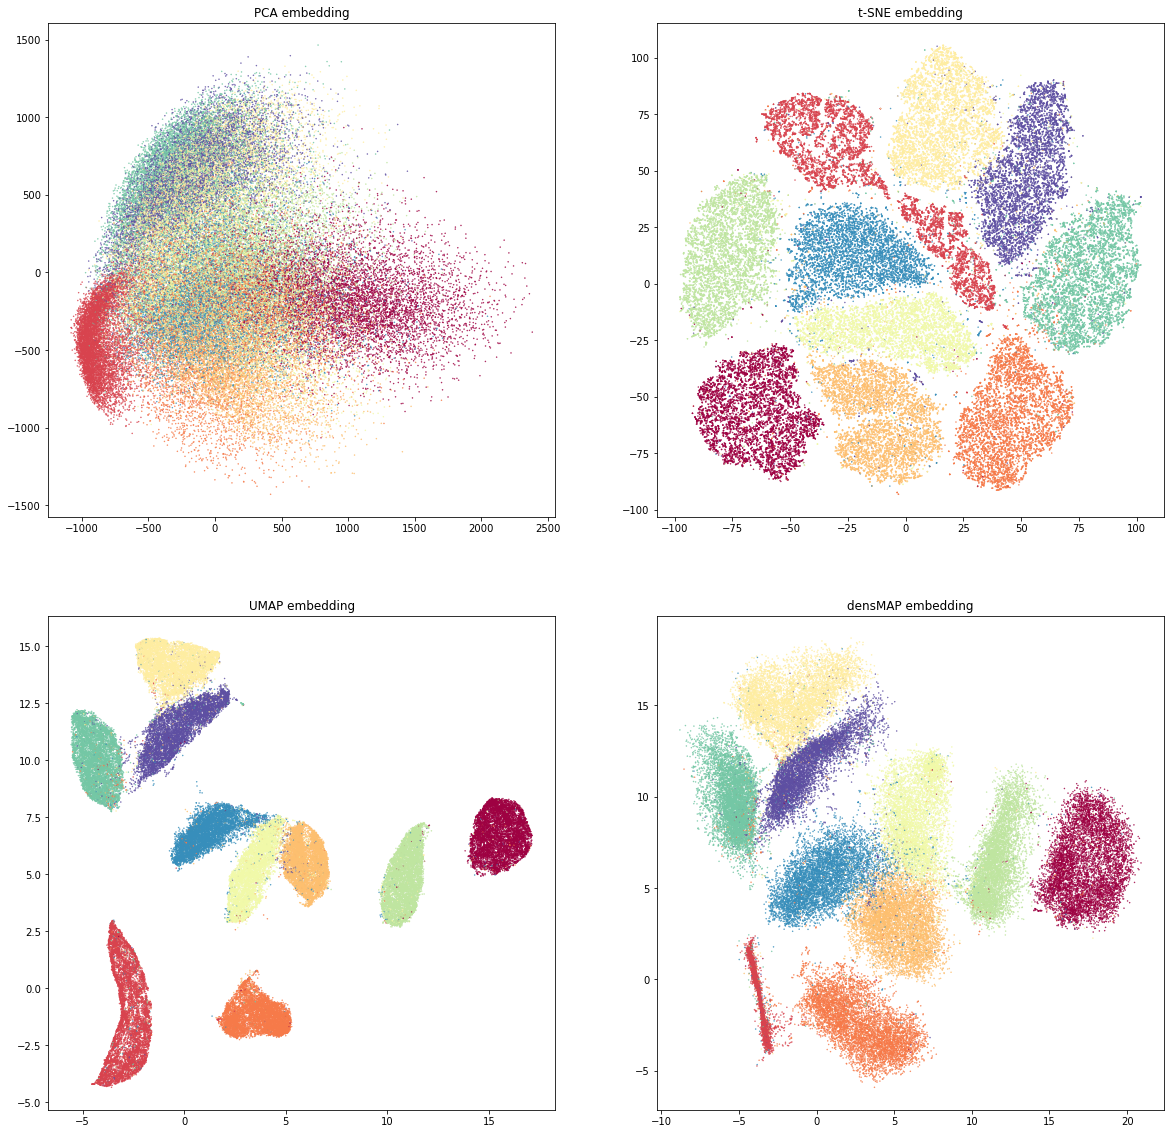

In [224]:
fig, ax = plt.subplots(2, 2, figsize =(20,20))

from sklearn.decomposition import PCA
pca_embedding = PCA(n_components = 2).fit_transform(mnist.data)
ax[0,0].scatter(*pca_embedding.T, s = 0.2, c=color,  cmap='Spectral')
ax[0,0].set_title('PCA embedding')

from sklearn.manifold import TSNE
tsne_embedding = TSNE(n_components = 2, learning_rate  = 'auto', init = 'random').fit_transform(mnist.data)
ax[0,1].scatter(*tsne_embedding.T, s = 0.2, c=color, cmap='Spectral')
ax[0,1].set_title('t-SNE embedding')

umap_embedding = umap.UMAP(random_state=42).fit_transform(mnist.data)
ax[1,0].scatter(*umap_embedding.T, s = 0.2, c=color, cmap='Spectral')
ax[1,0].set_title('UMAP embedding')

dens_embedding = umap.UMAP(densmap=True, random_state=42).fit_transform(mnist.data)
ax[1,1].scatter(*dens_embedding.T, s = 0.2, c=color,  cmap='Spectral')
ax[1,1].set_title('densMAP embedding')

plt.show()


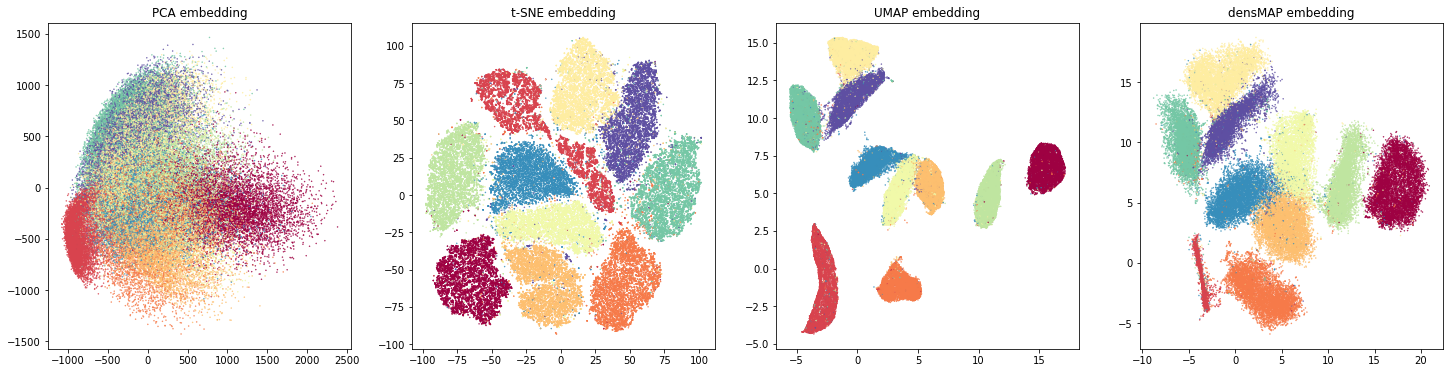

In [225]:
fig, ax = plt.subplots(1, 4, figsize =(25,6))

ax[0].scatter(*pca_embedding.T, s = 0.2, c=color,  cmap='Spectral')
ax[0].set_title('PCA embedding', fontsize = 40)

ax[1].scatter(*tsne_embedding.T, s = 0.2, c=color, cmap='Spectral')
ax[1].set_title('t-SNE embedding', fontsize = 40)

ax[2].scatter(*umap_embedding.T, s = 0.2, c=color, cmap='Spectral')
ax[2].set_title('UMAP embedding', fontsize = 40)

ax[3].scatter(*dens_embedding.T, s = 0.2, c=color,  cmap='Spectral')
ax[3].set_title('densMAP embedding', fontsize = 40)

plt.show()

## Gaussian Blobs

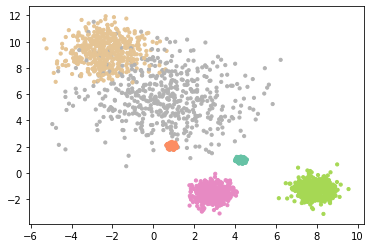

In [210]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y_true = make_blobs(
    n_samples=3000, centers=6, cluster_std=[0.1,0.1,0.5,0.5,1.0,2.0],
    random_state=0
)
X = X[:, ::-1]
plt.scatter(X[:,0],X[:,1], c = y_true, cmap ="Set2", s = 10)

In [184]:
new_data = convert_to_graph(X, n_neighbours = 50,features='coordinates',standardize=True)

Text(0.5, 1.0, 'PCA embedding')

Text(0.5, 1.0, 't-SNE embedding')

Text(0.5, 1.0, 'UMAP embedding')

Text(0.5, 1.0, 'densMAP embedding')

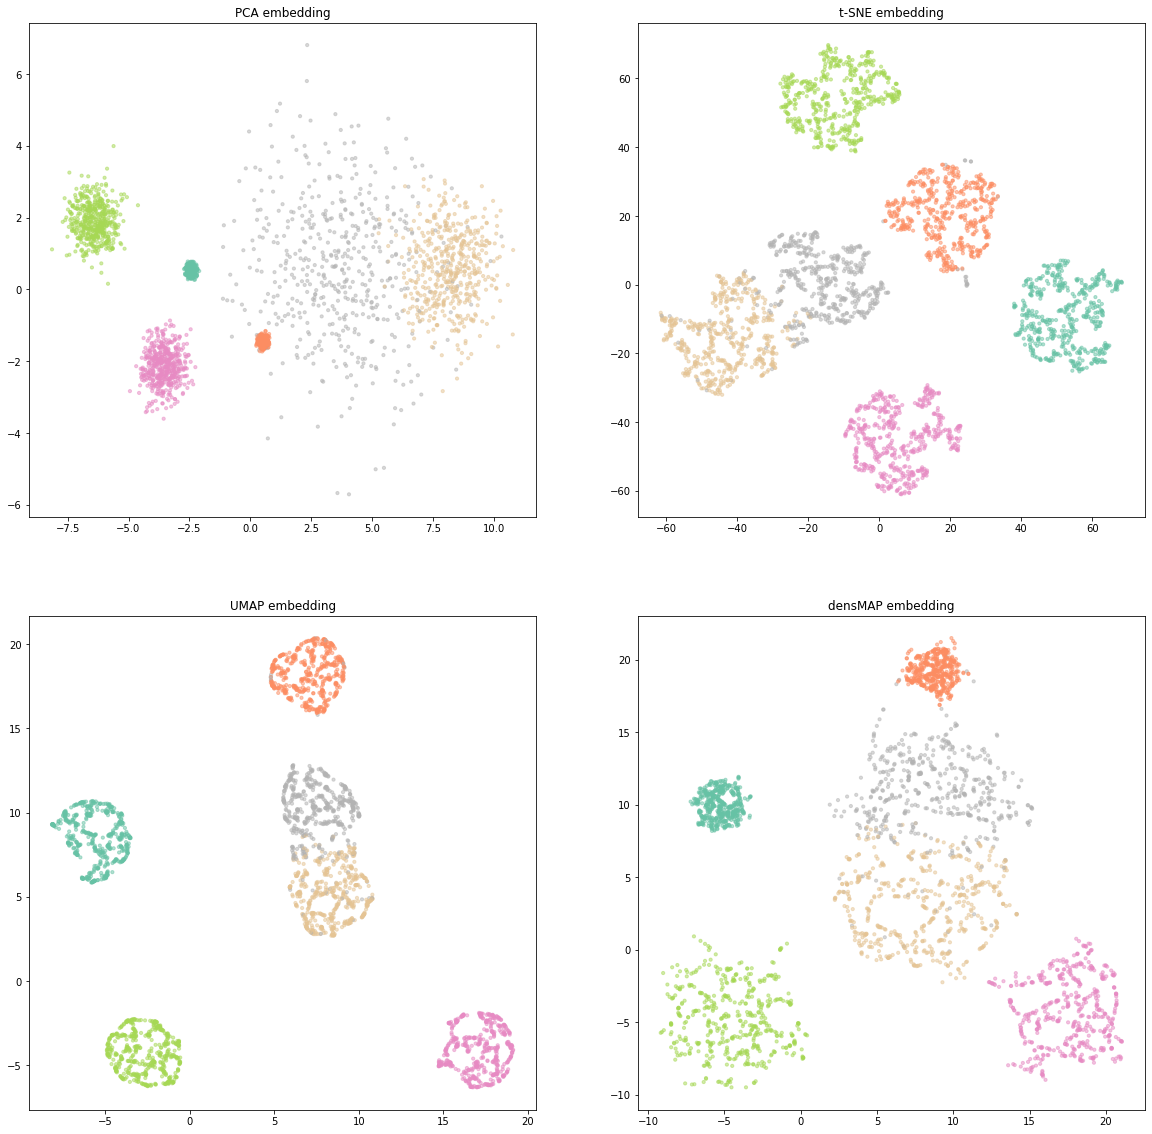

In [211]:
fig, ax = plt.subplots(2, 2, figsize =(20,20))

from sklearn.decomposition import PCA
pca_embedding = PCA(n_components = 2).fit_transform(X)
ax[0,0].scatter(*pca_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[0,0].set_title('PCA embedding')

from sklearn.manifold import TSNE
tsne_embedding = TSNE(n_components = 2, learning_rate  = 'auto', init = 'random').fit_transform(X)
ax[0,1].scatter(*tsne_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[0,1].set_title('t-SNE embedding')

umap_embedding = umap.UMAP(random_state=42).fit_transform(X)
ax[1,0].scatter(*umap_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[1,0].set_title('UMAP embedding')

dens_embedding = umap.UMAP(densmap=True, random_state=42).fit_transform(X)
ax[1,1].scatter(*dens_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[1,1].set_title('densMAP embedding')

plt.show()


In [186]:
cd notebooks/

/Users/sowonjeong/Documents/GitHub/gnumap/notebooks


Hyperparameters a = 1.89560586638432 and b = 0.8006378440415777
Epoch=000, loss=44.8784, time=2.1114
Epoch=001, loss=44.7257, time=2.6228
Epoch=002, loss=44.4548, time=2.2147
Epoch=003, loss=43.9979, time=2.1826
Epoch=004, loss=43.3045, time=2.2575
Epoch=005, loss=42.4373, time=2.2319
Epoch=006, loss=41.3777, time=2.3218
Epoch=007, loss=40.0877, time=2.2437
Epoch=008, loss=38.8161, time=2.0849
Epoch=009, loss=37.5293, time=2.1175
Epoch=010, loss=36.3696, time=1.8485
Epoch=011, loss=35.3149, time=2.2263
Epoch=012, loss=34.4289, time=2.1423
Epoch=013, loss=33.6314, time=2.0639
Epoch=014, loss=33.0036, time=2.1544
Epoch=015, loss=32.3951, time=2.5186
Epoch=016, loss=31.9298, time=3.0124
Epoch=017, loss=31.4785, time=4.0320
Epoch=018, loss=31.1109, time=5.1775
Epoch=019, loss=30.7377, time=3.9696
Epoch=020, loss=30.4252, time=3.1528
Epoch=021, loss=30.1133, time=2.4861
Epoch=022, loss=29.8494, time=2.2402
Epoch=023, loss=29.5690, time=2.2709
Epoch=024, loss=29.3216, time=2.6427
Epoch=025, 

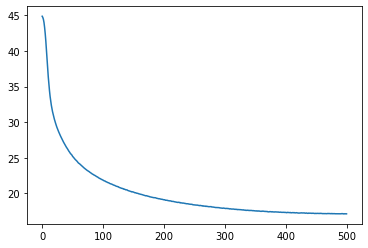

In [187]:
model, target_index, losses  = train_gnumap(new_data, 512, 2, n_layers=2, dropout_rate = 0.5, target=None,
                 patience=20, epochs=500, lr=1e-3, wd=1e-4, optim = 'SGD',
                 min_dist=0.01, name_file="1", subsampling=None,
                 spread = 1.0, repulsion_strength=None,
                 device=None, verbose = False, normalized = True)
out = model(new_data.x.float(), new_data.edge_index, new_data.edge_weight)
plt.plot(losses)

In [207]:
model_blob6 = model
loss_blob6 = losses

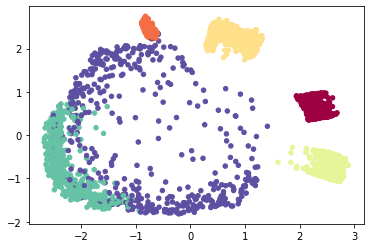

In [188]:
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = y_true, cmap = 'Spectral', s = 20)

Text(0.5, 1.0, 'Original')

Text(0.5, 1.0, 'PCA embedding')

Text(0.5, 1.0, 't-SNE embedding')

Text(0.5, 1.0, 'UMAP embedding')

Text(0.5, 1.0, 'densMAP embedding')

Text(0.5, 1.0, 'gnumap embedding')

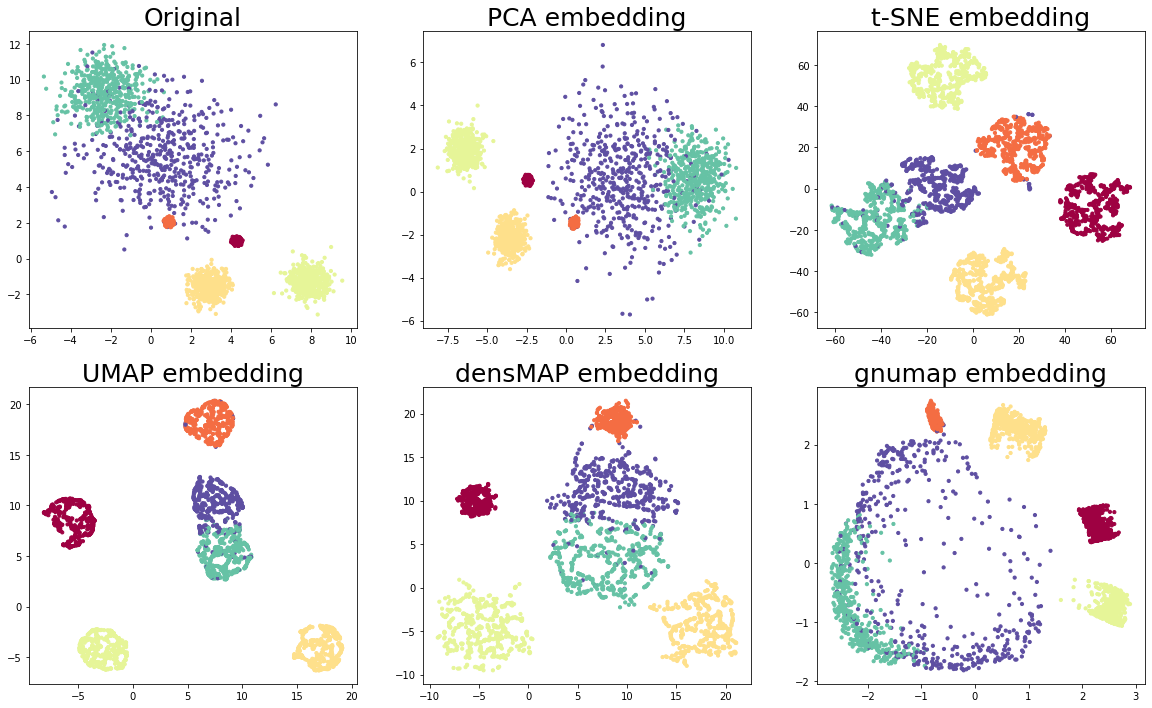

In [212]:
fig, ax = plt.subplots(2, 3, figsize =(20,12))

ax[0,0].scatter(X[:,0], X[:,1], s = 10, c=y_true,  cmap='Spectral')
ax[0,0].set_title('Original', fontsize = 25)

ax[0,1].scatter(*pca_embedding.T, s = 10, c=y_true,  cmap='Spectral')
ax[0,1].set_title('PCA embedding', fontsize = 25)

ax[0,2].scatter(*tsne_embedding.T, s = 10, c=y_true, cmap='Spectral')
ax[0,2].set_title('t-SNE embedding', fontsize = 25)

ax[1,0].scatter(*umap_embedding.T, s = 10, c=y_true, cmap='Spectral')
ax[1,0].set_title('UMAP embedding', fontsize = 25)

ax[1,1].scatter(*dens_embedding.T, s = 10, c=y_true,  cmap='Spectral')
ax[1,1].set_title('densMAP embedding', fontsize = 25)

ax[1,2].scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], s = 10, c=y_true,  cmap='Spectral')
ax[1,2].set_title('gnumap embedding', fontsize = 25)

plt.show()

In [71]:
from evaluation_metric import *

In [72]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [204]:
svm_eval(pca_embedding, y_true)
svm_eval(tsne_embedding, y_true)
svm_eval(umap_embedding, y_true)
svm_eval(dens_embedding, y_true)
svm_eval(out.detach().numpy(), y_true)

0.9343333333333333

0.9653333333333334

0.944

0.9603333333333332

0.9406666666666668

In [198]:
_,_,sp_pc, _ = spearman_correlation_eval(X, pca_embedding, random_seed = 0)
_,_,sp_tsne, _ = spearman_correlation_eval(X, tsne_embedding, random_seed = 0)
_,_,sp_umap, _ = spearman_correlation_eval(X, umap_embedding, random_seed = 0)
_,_,sp_dens, _= spearman_correlation_eval(X, dens_embedding, random_seed = 0)
_,_,sp_gnumap, _= spearman_correlation_eval(X, out.detach().numpy(), random_seed = 0)

In [199]:
sp_pc
sp_tsne
sp_umap
sp_dens
sp_gnumap

0.93616221323638

0.46476363210049626

0.1393241761936281

0.1515153929268334

0.7444512493445761

In [200]:
neighbor_kept_ratio_eval(new_data, pca_embedding, n_neighbors=50) # local structure 
neighbor_kept_ratio_eval(new_data, tsne_embedding, n_neighbors=50) # local structure 
neighbor_kept_ratio_eval(new_data, umap_embedding, n_neighbors=50) # local structure 
neighbor_kept_ratio_eval(new_data, dens_embedding, n_neighbors=50) # local structure
neighbor_kept_ratio_eval(new_data, out, n_neighbors=50) # local structure  

tensor(0.8040)

tensor(0.7493)

tensor(0.7320)

tensor(0.6618)

tensor(0.3417)

In [202]:
eval_density_preserve(X, pca_embedding)
eval_density_preserve(X, tsne_embedding)
eval_density_preserve(X, umap_embedding)
eval_density_preserve(X, dens_embedding)
eval_density_preserve(X, out.detach().numpy())

0.970596396761241

0.38432352900942296

0.5178118069498083

0.7560736170423796

0.882129336112899

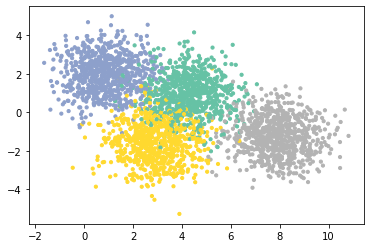

In [219]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y_true = make_blobs(
    n_samples=3000, centers=4, cluster_std=1.0,
    random_state=0
)
X = X[:, ::-1]
plt.scatter(X[:,0],X[:,1], c = y_true, cmap ="Set2", s = 10)

In [220]:
new_data = convert_to_graph(X, n_neighbours = 50,features='coordinates',standardize=True)

Text(0.5, 1.0, 'PCA embedding')

Text(0.5, 1.0, 't-SNE embedding')

Text(0.5, 1.0, 'UMAP embedding')

Text(0.5, 1.0, 'densMAP embedding')

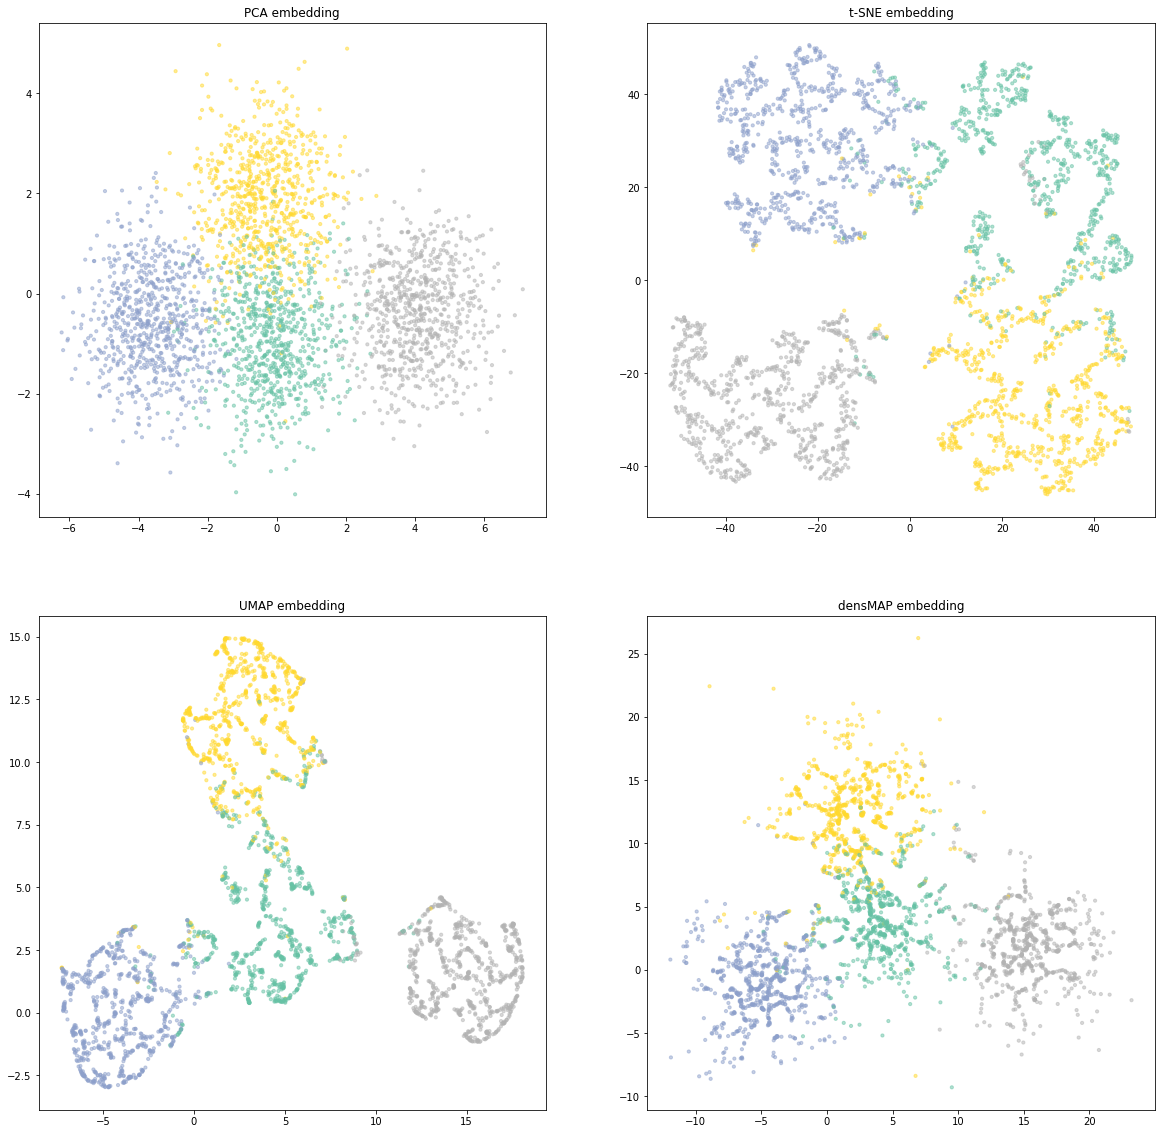

In [221]:
fig, ax = plt.subplots(2, 2, figsize =(20,20))

from sklearn.decomposition import PCA
pca_embedding = PCA(n_components = 2).fit_transform(X)
ax[0,0].scatter(*pca_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[0,0].set_title('PCA embedding')

from sklearn.manifold import TSNE
tsne_embedding = TSNE(n_components = 2, learning_rate  = 'auto', init = 'random').fit_transform(X)
ax[0,1].scatter(*tsne_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[0,1].set_title('t-SNE embedding')

umap_embedding = umap.UMAP(random_state=42).fit_transform(X)
ax[1,0].scatter(*umap_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[1,0].set_title('UMAP embedding')

dens_embedding = umap.UMAP(densmap=True, random_state=42).fit_transform(X)
ax[1,1].scatter(*dens_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[1,1].set_title('densMAP embedding')

plt.show()


Hyperparameters a = 1.89560586638432 and b = 0.8006378440415777
Epoch=000, loss=51.8025, time=2.3085
Epoch=001, loss=51.7547, time=2.7642
Epoch=002, loss=51.5714, time=2.5029
Epoch=003, loss=51.2334, time=2.2918
Epoch=004, loss=50.7169, time=2.3296
Epoch=005, loss=49.9316, time=2.2472
Epoch=006, loss=48.9334, time=2.2599
Epoch=007, loss=47.7307, time=2.0757
Epoch=008, loss=46.3813, time=1.8161
Epoch=009, loss=45.0700, time=2.1070
Epoch=010, loss=43.8165, time=2.2803
Epoch=011, loss=42.6593, time=2.7615
Epoch=012, loss=41.5615, time=2.1289
Epoch=013, loss=40.5835, time=1.8773
Epoch=014, loss=39.7068, time=1.7376
Epoch=015, loss=38.8923, time=1.9069
Epoch=016, loss=38.1892, time=1.8535
Epoch=017, loss=37.5675, time=1.7131
Epoch=018, loss=36.9896, time=1.9909
Epoch=019, loss=36.4225, time=1.7956
Epoch=020, loss=35.9164, time=1.8705
Epoch=021, loss=35.4343, time=1.7922
Epoch=022, loss=35.0253, time=1.8201
Epoch=023, loss=34.6207, time=1.8920
Epoch=024, loss=34.2229, time=1.7083
Epoch=025, 

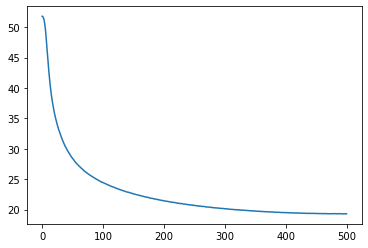

In [222]:
model, target_index, losses  = train_gnumap(new_data, 512, 2, n_layers=2, dropout_rate = 0.5, target=None,
                 patience=20, epochs=500, lr=1e-3, wd=1e-4, optim = 'SGD',
                 min_dist=0.01, name_file="1", subsampling=None,
                 spread = 1.0, repulsion_strength=None,
                 device=None, verbose = False, normalized = True)
out = model(new_data.x.float(), new_data.edge_index, new_data.edge_weight)
plt.plot(losses)

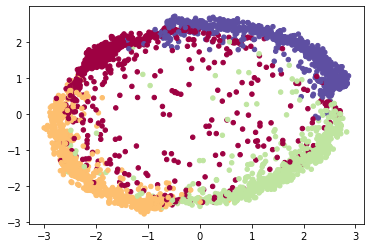

In [223]:
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = y_true, cmap = 'Spectral', s = 20)

In [224]:
model_blob4 = model
loss_blob4 = losses

Text(0.5, 1.0, 'Original')

Text(0.5, 1.0, 'PCA embedding')

Text(0.5, 1.0, 't-SNE embedding')

Text(0.5, 1.0, 'UMAP embedding')

Text(0.5, 1.0, 'densMAP embedding')

Text(0.5, 1.0, 'gnumap embedding')

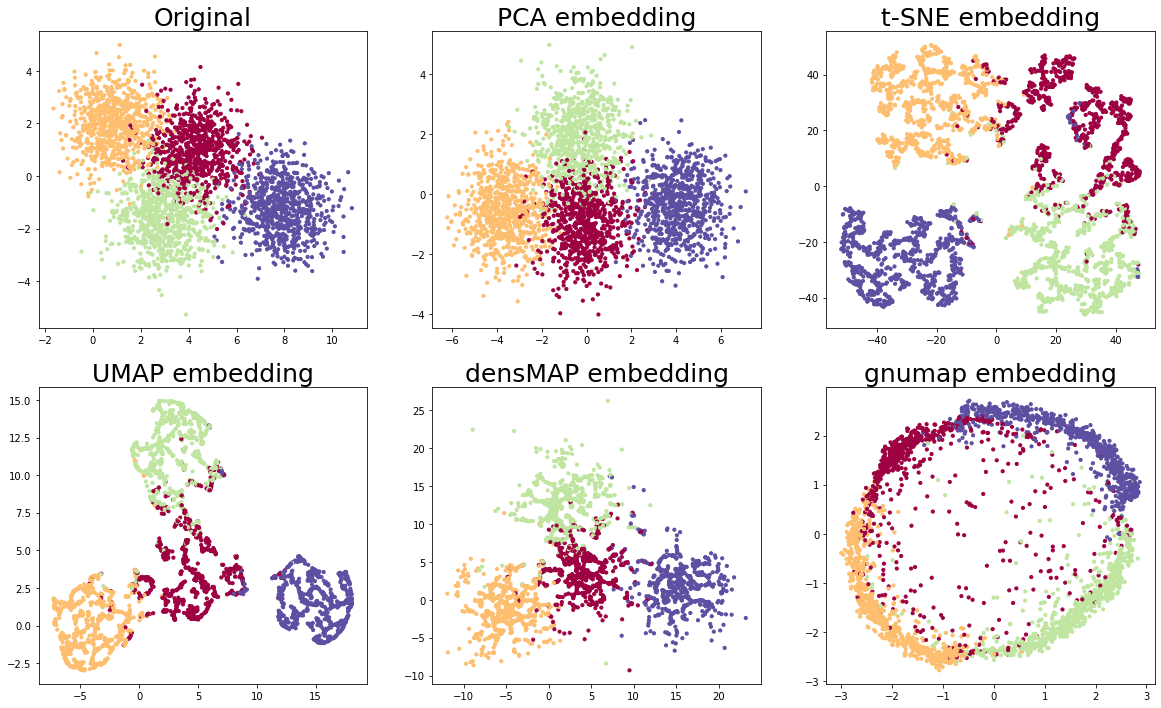

In [225]:
fig, ax = plt.subplots(2, 3, figsize =(20,12))

ax[0,0].scatter(X[:,0], X[:,1], s = 10, c=y_true,  cmap='Spectral')
ax[0,0].set_title('Original', fontsize = 25)

ax[0,1].scatter(*pca_embedding.T, s = 10, c=y_true,  cmap='Spectral')
ax[0,1].set_title('PCA embedding', fontsize = 25)

ax[0,2].scatter(*tsne_embedding.T, s = 10, c=y_true, cmap='Spectral')
ax[0,2].set_title('t-SNE embedding', fontsize = 25)

ax[1,0].scatter(*umap_embedding.T, s = 10, c=y_true, cmap='Spectral')
ax[1,0].set_title('UMAP embedding', fontsize = 25)

ax[1,1].scatter(*dens_embedding.T, s = 10, c=y_true,  cmap='Spectral')
ax[1,1].set_title('densMAP embedding', fontsize = 25)

ax[1,2].scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], s = 10, c=y_true,  cmap='Spectral')
ax[1,2].set_title('gnumap embedding', fontsize = 25)

plt.show()

In [227]:
_,_,sp_pc, _ = spearman_correlation_eval(X, pca_embedding, random_seed = 0)
_,_,sp_tsne, _ = spearman_correlation_eval(X, tsne_embedding, random_seed = 0)
_,_,sp_umap, _ = spearman_correlation_eval(X, umap_embedding, random_seed = 0)
_,_,sp_dens, _= spearman_correlation_eval(X, dens_embedding, random_seed = 0)
_,_,sp_gnumap, _= spearman_correlation_eval(X, out.detach().numpy(), random_seed = 0)

In [228]:
sp_pc
sp_tsne
sp_umap
sp_dens
sp_gnumap

0.8758553291726666

0.5926889475519074

0.8434094280255974

0.8266237369728532

0.5512645381248842

In [229]:
svm_eval(pca_embedding, y_true)
svm_eval(tsne_embedding, y_true)
svm_eval(umap_embedding, y_true)
svm_eval(dens_embedding, y_true)
svm_eval(out.detach().numpy(), y_true)

0.9289999999999999

0.9323333333333332

0.898

0.9023333333333333

0.8736666666666666

In [230]:
neighbor_kept_ratio_eval(new_data, pca_embedding, n_neighbors=50) # local structure 
neighbor_kept_ratio_eval(new_data, tsne_embedding, n_neighbors=50) # local structure 
neighbor_kept_ratio_eval(new_data, umap_embedding, n_neighbors=50) # local structure 
neighbor_kept_ratio_eval(new_data, dens_embedding, n_neighbors=50) # local structure 
neighbor_kept_ratio_eval(new_data, out, n_neighbors=50) # local structure 

tensor(0.8511)

tensor(0.7460)

tensor(0.7261)

tensor(0.6905)

tensor(0.3434)

In [231]:
eval_density_preserve(X, pca_embedding)
eval_density_preserve(X, tsne_embedding)
eval_density_preserve(X, umap_embedding)
eval_density_preserve(X, dens_embedding)
eval_density_preserve(X, out.detach().numpy())

0.8224659839309766

0.14485873836991892

0.5570610508046718

0.8486032353109625

0.15204449579156792

## Circles

Text(0.5, 1.0, 'PCA embedding')

Text(0.5, 1.0, 't-SNE embedding')

Text(0.5, 1.0, 'UMAP embedding')

Text(0.5, 1.0, 'densMAP embedding')

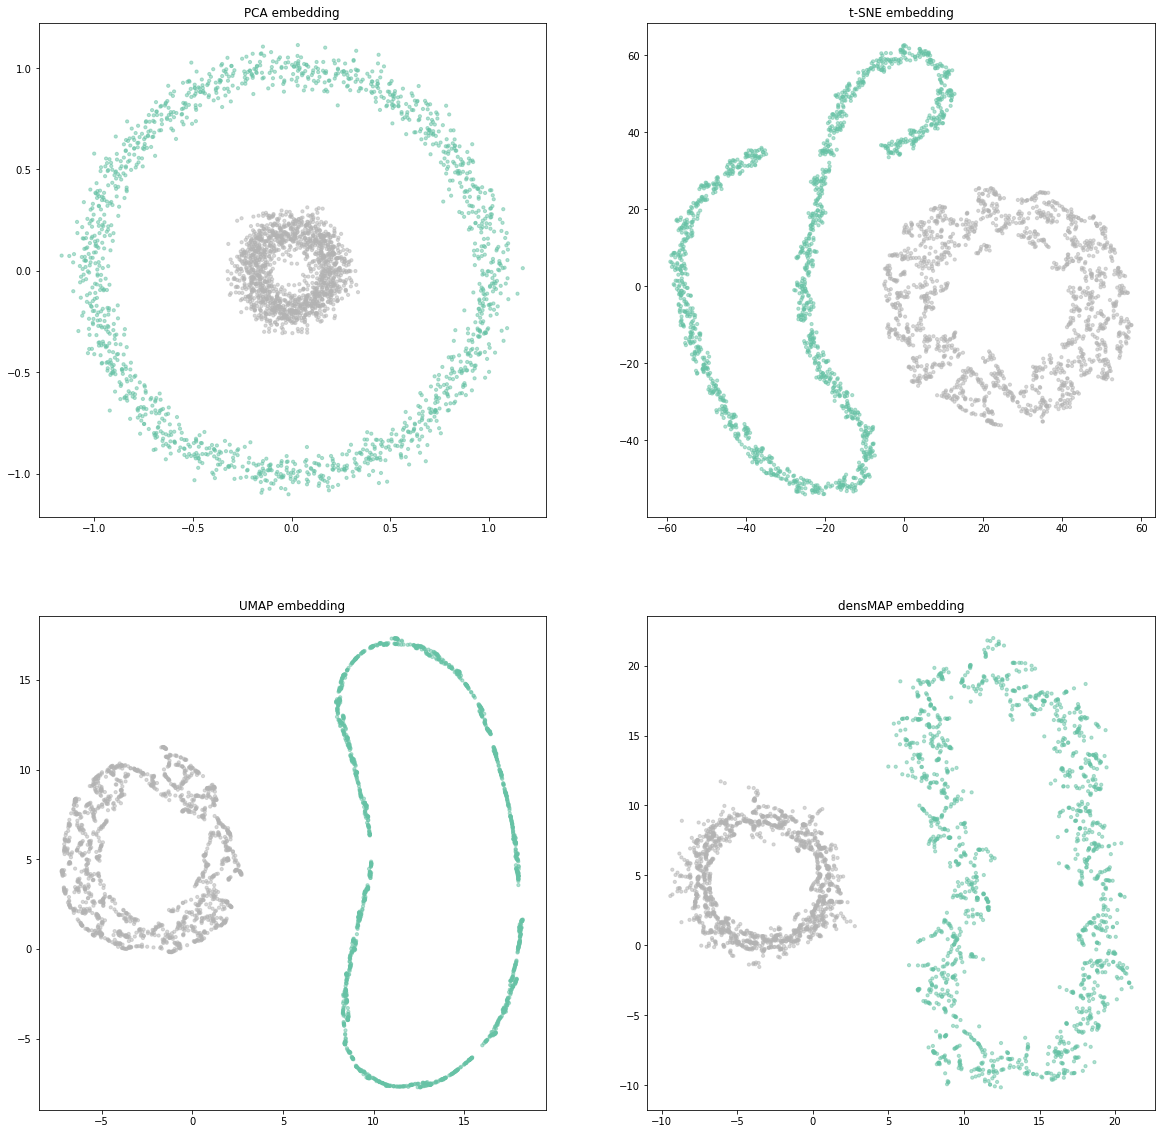

In [238]:
from sklearn import manifold, datasets

X, y_true = datasets.make_circles(
    n_samples=3000, factor=0.2, noise=0.05, random_state=0
)

fig, ax = plt.subplots(2, 2, figsize =(20,20))

from sklearn.decomposition import PCA
pca_embedding = PCA(n_components = 2).fit_transform(X)
ax[0,0].scatter(*pca_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[0,0].set_title('PCA embedding')

from sklearn.manifold import TSNE
tsne_embedding = TSNE(n_components = 2, learning_rate  = 'auto', init = 'random').fit_transform(X)
ax[0,1].scatter(*tsne_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[0,1].set_title('t-SNE embedding')

umap_embedding = umap.UMAP(random_state=42).fit_transform(X)
ax[1,0].scatter(*umap_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[1,0].set_title('UMAP embedding')

dens_embedding = umap.UMAP(densmap=True, random_state=42).fit_transform(X)
ax[1,1].scatter(*dens_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[1,1].set_title('densMAP embedding')

plt.show()

In [239]:
new_data = convert_to_graph(X, n_neighbours = 50,features='coordinates',standardize=True)

Hyperparameters a = 1.89560586638432 and b = 0.8006378440415777
Epoch=000, loss=40.4928, time=1.9034
Epoch=001, loss=40.3917, time=1.7763
Epoch=002, loss=40.1227, time=1.8266
Epoch=003, loss=39.5672, time=2.1379
Epoch=004, loss=38.6429, time=1.9564
Epoch=005, loss=37.3222, time=1.7481
Epoch=006, loss=35.8330, time=1.7850
Epoch=007, loss=34.3321, time=1.7870
Epoch=008, loss=32.9182, time=1.7937
Epoch=009, loss=31.5848, time=1.6069
Epoch=010, loss=30.4370, time=1.6433
Epoch=011, loss=29.4606, time=1.8047
Epoch=012, loss=28.5137, time=1.7240
Epoch=013, loss=27.6271, time=1.7639
Epoch=014, loss=26.8723, time=1.5790
Epoch=015, loss=26.0908, time=1.7104
Epoch=016, loss=25.3941, time=1.7218
Epoch=017, loss=24.7524, time=1.7069
Epoch=018, loss=24.1708, time=1.6681
Epoch=019, loss=23.6106, time=1.7074
Epoch=020, loss=23.1053, time=1.6700
Epoch=021, loss=22.6279, time=1.7150
Epoch=022, loss=22.1851, time=1.6512
Epoch=023, loss=21.7886, time=1.6473
Epoch=024, loss=21.4193, time=1.7290
Epoch=025, 

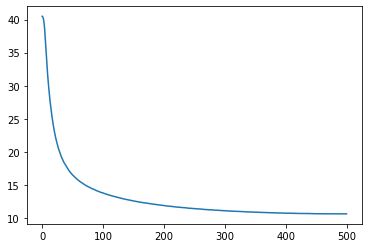

In [240]:
model, target_index, losses  = train_gnumap(new_data, 512, 2, n_layers=2, dropout_rate = 0.5, target=None,
                 patience=20, epochs=500, lr=1e-3, wd=1e-4, optim = 'SGD',
                 min_dist=0.01, name_file="1", subsampling=None,
                 spread = 1.0, repulsion_strength=None,
                 device=None, verbose = False, normalized = True)
out = model(new_data.x.float(), new_data.edge_index, new_data.edge_weight)
plt.plot(losses)

In [241]:
model_circles = model
loss_circles = losses

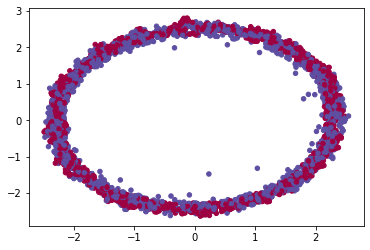

In [242]:
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = y_true, cmap = 'Spectral', s = 20)

Text(0.5, 1.0, 'Original')

Text(0.5, 1.0, 'PCA embedding')

Text(0.5, 1.0, 't-SNE embedding')

Text(0.5, 1.0, 'UMAP embedding')

Text(0.5, 1.0, 'densMAP embedding')

Text(0.5, 1.0, 'gnumap embedding')

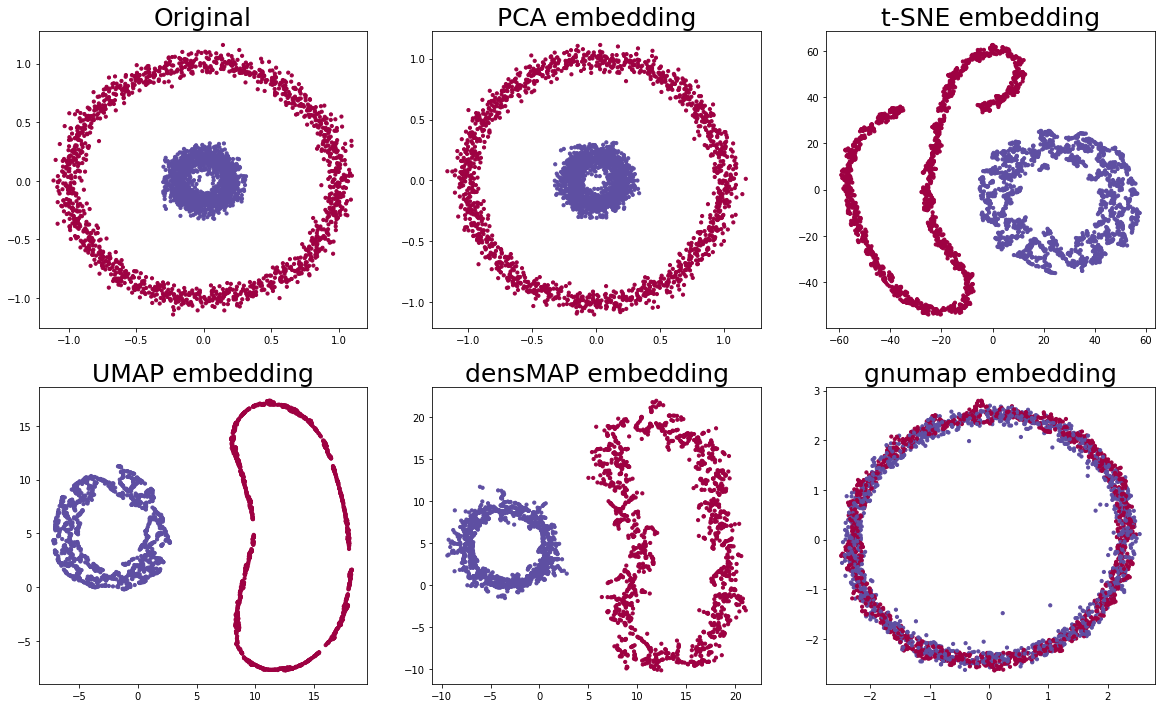

In [243]:
fig, ax = plt.subplots(2, 3, figsize =(20,12))

ax[0,0].scatter(X[:,0], X[:,1], s = 10, c=y_true,  cmap='Spectral')
ax[0,0].set_title('Original', fontsize = 25)

ax[0,1].scatter(*pca_embedding.T, s = 10, c=y_true,  cmap='Spectral')
ax[0,1].set_title('PCA embedding', fontsize = 25)

ax[0,2].scatter(*tsne_embedding.T, s = 10, c=y_true, cmap='Spectral')
ax[0,2].set_title('t-SNE embedding', fontsize = 25)

ax[1,0].scatter(*umap_embedding.T, s = 10, c=y_true, cmap='Spectral')
ax[1,0].set_title('UMAP embedding', fontsize = 25)

ax[1,1].scatter(*dens_embedding.T, s = 10, c=y_true,  cmap='Spectral')
ax[1,1].set_title('densMAP embedding', fontsize = 25)

ax[1,2].scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], s = 10, c=y_true,  cmap='Spectral')
ax[1,2].set_title('gnumap embedding', fontsize = 25)

plt.show()

In [244]:
_,_,sp_pc, _ = spearman_correlation_eval(X, pca_embedding, random_seed = 0)
_,_,sp_tsne, _ = spearman_correlation_eval(X, tsne_embedding, random_seed = 0)
_,_,sp_umap, _ = spearman_correlation_eval(X, umap_embedding, random_seed = 0)
_,_,sp_dens, _= spearman_correlation_eval(X, dens_embedding, random_seed = 0)
_,_,sp_gnumap, _= spearman_correlation_eval(X, out.detach().numpy(), random_seed = 0)

In [245]:
sp_pc
sp_tsne
sp_umap
sp_dens
sp_gnumap

0.7488854457339374

0.408110283961988

0.43431512147401485

0.438451497909816

0.3919485699607379

In [246]:
svm_eval(pca_embedding, y_true)
svm_eval(tsne_embedding, y_true)
svm_eval(umap_embedding, y_true)
svm_eval(dens_embedding, y_true)
svm_eval(out.detach().numpy(), y_true)

0.48266666666666663

0.9406666666666667

1.0

1.0

0.48533333333333334

In [247]:
neighbor_kept_ratio_eval(new_data, pca_embedding, n_neighbors=50) # local structure 
neighbor_kept_ratio_eval(new_data, tsne_embedding, n_neighbors=50) # local structure 
neighbor_kept_ratio_eval(new_data, umap_embedding, n_neighbors=50) # local structure 
neighbor_kept_ratio_eval(new_data, dens_embedding, n_neighbors=50) # local structure
neighbor_kept_ratio_eval(new_data, out.detach().numpy(), n_neighbors=50) # local structure  

tensor(0.8755)

tensor(0.8197)

tensor(0.7907)

tensor(0.6551)

tensor(0.3535)

In [248]:
eval_density_preserve(X, pca_embedding)
eval_density_preserve(X, tsne_embedding)
eval_density_preserve(X, umap_embedding)
eval_density_preserve(X, dens_embedding)
eval_density_preserve(X, out.detach().numpy())

0.999997536869952

-0.4608665899921165

0.7399195053067399

0.9227289196670818

0.027800417772281347

## Moons

Text(0.5, 1.0, 'PCA embedding')

Text(0.5, 1.0, 't-SNE embedding')

Text(0.5, 1.0, 'UMAP embedding')

Text(0.5, 1.0, 'densMAP embedding')

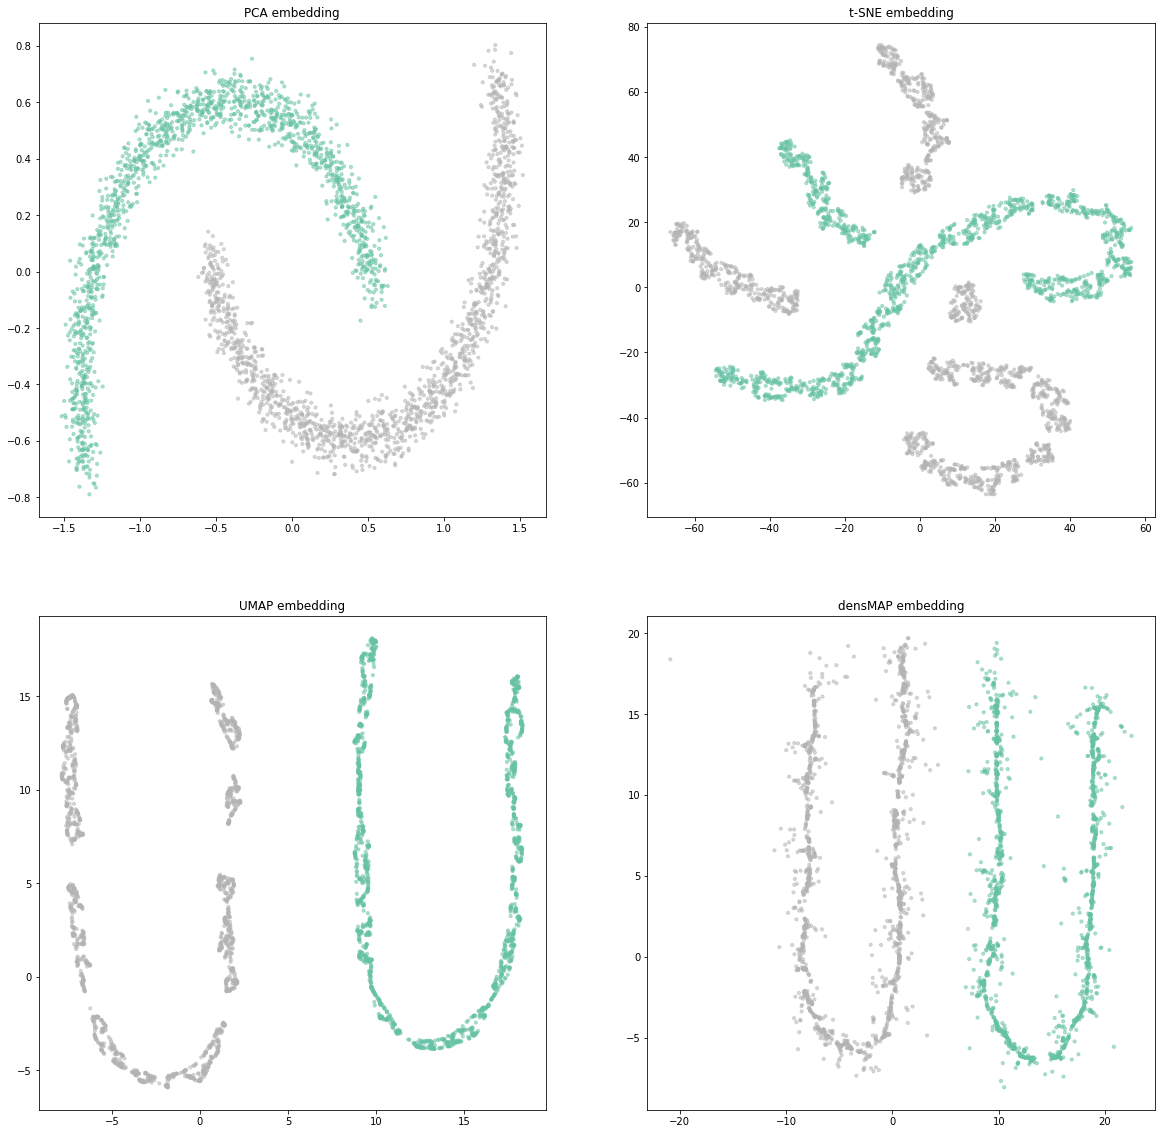

In [249]:
from sklearn import manifold, datasets

X, y_true = datasets.make_moons(
    n_samples=3000, noise=0.05, random_state=0
)

fig, ax = plt.subplots(2, 2, figsize =(20,20))

from sklearn.decomposition import PCA
pca_embedding = PCA(n_components = 2).fit_transform(X)
ax[0,0].scatter(*pca_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[0,0].set_title('PCA embedding')

from sklearn.manifold import TSNE
tsne_embedding = TSNE(n_components = 2, learning_rate  = 'auto', init = 'random').fit_transform(X)
ax[0,1].scatter(*tsne_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[0,1].set_title('t-SNE embedding')

umap_embedding = umap.UMAP(random_state=42).fit_transform(X)
ax[1,0].scatter(*umap_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[1,0].set_title('UMAP embedding')

dens_embedding = umap.UMAP(densmap=True, random_state=42).fit_transform(X)
ax[1,1].scatter(*dens_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[1,1].set_title('densMAP embedding')

plt.show()

In [250]:
new_data = convert_to_graph(X, n_neighbours = 50,features='coordinates',standardize=True)

In [251]:
model, target_index, losses  = train_gnumap(new_data, 512, 2, n_layers=2, dropout_rate = 0.5, target=None,
                 patience=20, epochs=500, lr=1e-3, wd=1e-4, optim = 'SGD',
                 min_dist=0.01, name_file="1", subsampling=None,
                 spread = 1.0, repulsion_strength=None,
                 device=None, verbose = False, normalized = True)
out = model(new_data.x.float(), new_data.edge_index, new_data.edge_weight)
plt.plot(losses)

Hyperparameters a = 1.89560586638432 and b = 0.8006378440415777
Epoch=000, loss=38.8495, time=2.6305
Epoch=001, loss=38.6823, time=2.5594
Epoch=002, loss=38.3466, time=2.4572
Epoch=003, loss=37.7901, time=2.4340
Epoch=004, loss=36.8674, time=2.2171
Epoch=005, loss=35.7185, time=2.1449
Epoch=006, loss=34.3702, time=2.0143
Epoch=007, loss=32.8628, time=2.1347
Epoch=008, loss=31.2937, time=2.3357
Epoch=009, loss=29.9224, time=2.5653
Epoch=010, loss=28.6047, time=2.2662
Epoch=011, loss=27.4113, time=2.2609
Epoch=012, loss=26.4046, time=2.7032
Epoch=013, loss=25.5299, time=2.3418
Epoch=014, loss=24.7458, time=2.4046
Epoch=015, loss=24.0617, time=2.2277
Epoch=016, loss=23.4688, time=2.1739
Epoch=017, loss=22.9284, time=2.7759
Epoch=018, loss=22.4381, time=2.5963
Epoch=019, loss=22.0309, time=2.4462
Epoch=020, loss=21.6448, time=2.3719
Epoch=021, loss=21.2605, time=2.7879
Epoch=022, loss=20.9321, time=2.4927
Epoch=023, loss=20.6083, time=2.4387
Epoch=024, loss=20.3391, time=2.5496
Epoch=025, 

In [ ]:
model_moons = model
loss_moons = losses

In [ ]:
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = y_true, cmap = 'Spectral', s = 20)

Text(0.5, 1.0, 'PCA embedding')

Text(0.5, 1.0, 't-SNE embedding')

Text(0.5, 1.0, 'UMAP embedding')

Text(0.5, 1.0, 'densMAP embedding')

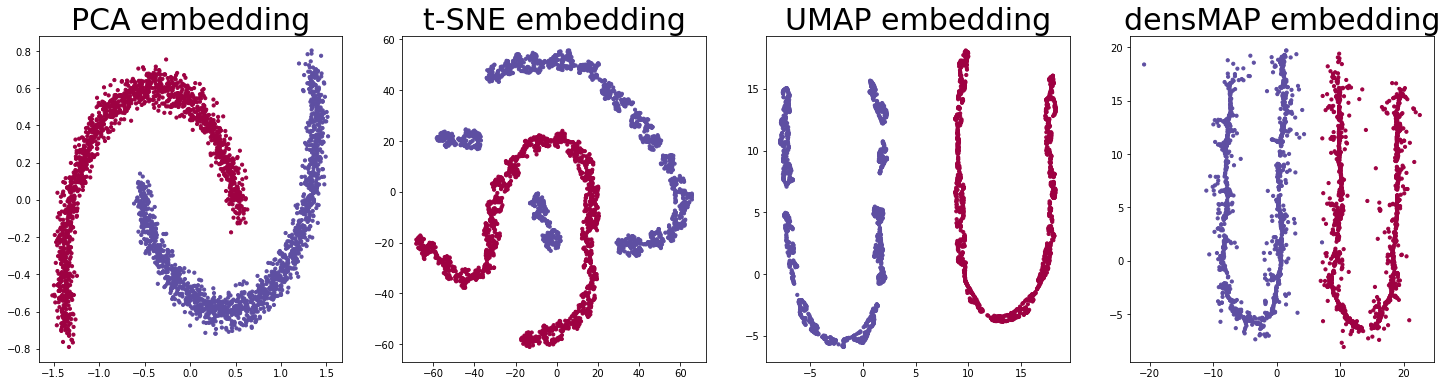

In [144]:
fig, ax = plt.subplots(2, 3, figsize =(20,12))

ax[0,0].scatter(X[:,0], X[:,1], s = 10, c=y_true,  cmap='Spectral')
ax[0,0].set_title('Original', fontsize = 25)

ax[0,1].scatter(*pca_embedding.T, s = 10, c=y_true,  cmap='Spectral')
ax[0,1].set_title('PCA embedding', fontsize = 25)

ax[0,2].scatter(*tsne_embedding.T, s = 10, c=y_true, cmap='Spectral')
ax[0,2].set_title('t-SNE embedding', fontsize = 25)

ax[1,0].scatter(*umap_embedding.T, s = 10, c=y_true, cmap='Spectral')
ax[1,0].set_title('UMAP embedding', fontsize = 25)

ax[1,1].scatter(*dens_embedding.T, s = 10, c=y_true,  cmap='Spectral')
ax[1,1].set_title('densMAP embedding', fontsize = 25)

ax[1,2].scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], s = 10, c=y_true,  cmap='Spectral')
ax[1,2].set_title('gnumap embedding', fontsize = 25)

plt.show()

In [145]:
_,_,sp_pc, _ = spearman_correlation_eval(X, pca_embedding, random_seed = 0)
_,_,sp_tsne, _ = spearman_correlation_eval(X, tsne_embedding, random_seed = 0)
_,_,sp_umap, _ = spearman_correlation_eval(X, umap_embedding, random_seed = 0)
_,_,sp_dens, _= spearman_correlation_eval(X, dens_embedding, random_seed = 0)

In [146]:
sp_pc
sp_tsne
sp_umap
sp_dens

0.9347884340218152

0.36602912519329006

0.6438011353292408

0.6323107928043913

In [147]:
svm_eval(pca_embedding, y_true)
svm_eval(tsne_embedding, y_true)
svm_eval(umap_embedding, y_true)
svm_eval(dens_embedding, y_true)

0.8856666666666667

0.7169999999999999

1.0

0.9996666666666666

In [148]:
new_data = convert_to_graph(X, n_neighbours = 50,features='coordinates',standardize=True)

In [149]:
neighbor_kept_ratio_eval(new_data, pca_embedding, n_neighbors=50) # local structure 
neighbor_kept_ratio_eval(new_data, tsne_embedding, n_neighbors=50) # local structure 
neighbor_kept_ratio_eval(new_data, umap_embedding, n_neighbors=50) # local structure 
neighbor_kept_ratio_eval(new_data, dens_embedding, n_neighbors=50) # local structure 

tensor(0.8426)

tensor(0.7821)

tensor(0.7272)

tensor(0.6766)

In [150]:
eval_density_preserve(X, pca_embedding)
eval_density_preserve(X, tsne_embedding)
eval_density_preserve(X, umap_embedding)
eval_density_preserve(X, dens_embedding)

0.9951012327873462

-0.0965601564894618

-0.33347401052711095

0.1628138539130731

## Swissroll

Text(0.5, 1.0, 'PCA embedding')

Text(0.5, 1.0, 't-SNE embedding')

Text(0.5, 1.0, 'UMAP embedding')

Text(0.5, 1.0, 'densMAP embedding')

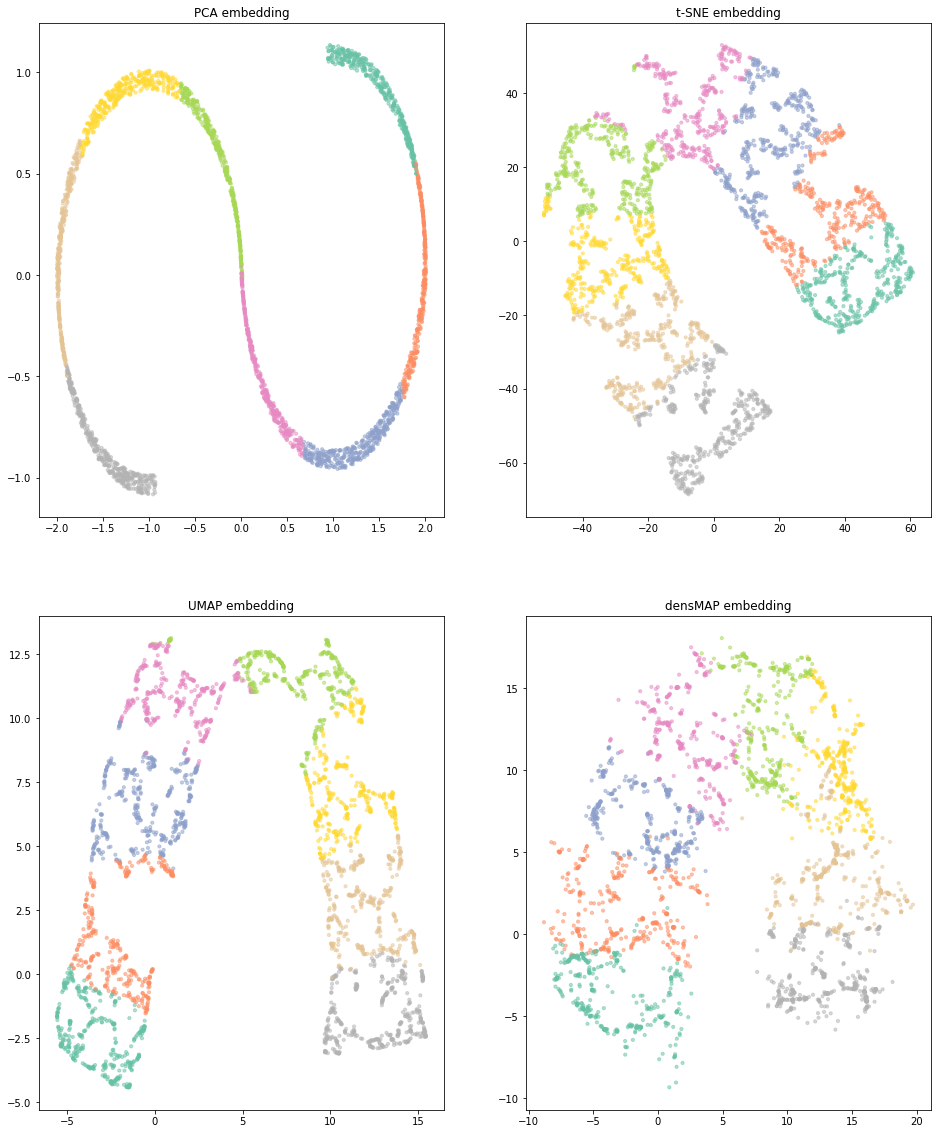

In [151]:
X, y_true = datasets.make_s_curve(n_samples = 3000, random_state=0)

fig, ax = plt.subplots(2, 2, figsize =(16,20))

from sklearn.decomposition import PCA
pca_embedding = PCA(n_components = 2).fit_transform(X)
ax[0,0].scatter(*pca_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[0,0].set_title('PCA embedding')

from sklearn.manifold import TSNE
tsne_embedding = TSNE(n_components = 2, learning_rate  = 'auto', init = 'random').fit_transform(X)
ax[0,1].scatter(*tsne_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[0,1].set_title('t-SNE embedding')

umap_embedding = umap.UMAP(random_state=42).fit_transform(X)
ax[1,0].scatter(*umap_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[1,0].set_title('UMAP embedding')

dens_embedding = umap.UMAP(densmap=True, random_state=42).fit_transform(X)
ax[1,1].scatter(*dens_embedding.T, s = 10, c=y_true, alpha=0.5, cmap='Set2')
ax[1,1].set_title('densMAP embedding')

plt.show()

Text(0.5, 1.0, 'PCA embedding')

Text(0.5, 1.0, 't-SNE embedding')

Text(0.5, 1.0, 'UMAP embedding')

Text(0.5, 1.0, 'densMAP embedding')

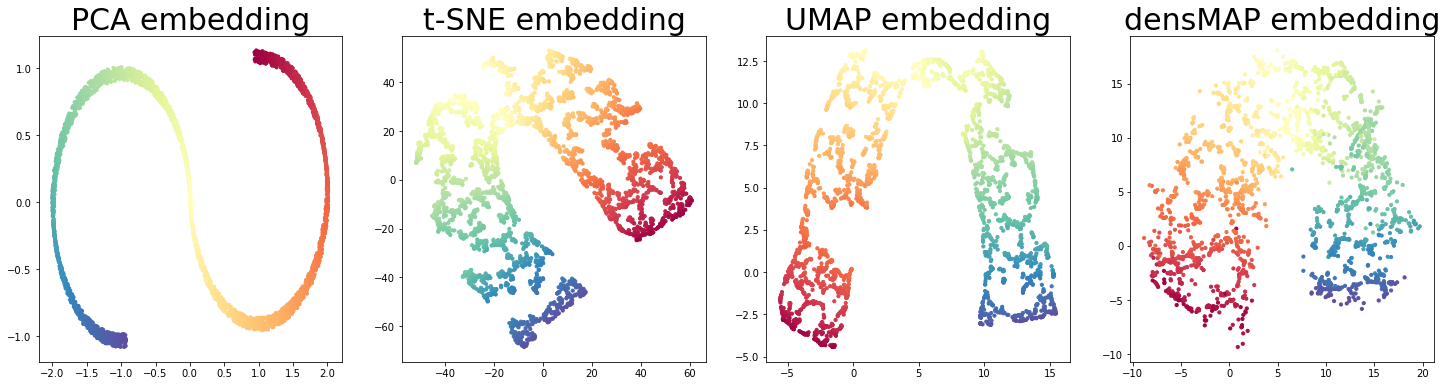

In [152]:
fig, ax = plt.subplots(1, 4, figsize =(25,6))

ax[0].scatter(*pca_embedding.T, s = 10, c=y_true,  cmap='Spectral')
ax[0].set_title('PCA embedding', fontsize = 30)

ax[1].scatter(*tsne_embedding.T, s = 10, c=y_true, cmap='Spectral')
ax[1].set_title('t-SNE embedding', fontsize = 30)

ax[2].scatter(*umap_embedding.T, s = 10, c=y_true, cmap='Spectral')
ax[2].set_title('UMAP embedding', fontsize = 30)

ax[3].scatter(*dens_embedding.T, s = 10, c=y_true,  cmap='Spectral')
ax[3].set_title('densMAP embedding', fontsize = 30)

plt.show()

In [153]:
_,_,sp_pc, _ = spearman_correlation_eval(X, pca_embedding, random_seed = 0)
_,_,sp_tsne, _ = spearman_correlation_eval(X, tsne_embedding, random_seed = 0)
_,_,sp_umap, _ = spearman_correlation_eval(X, umap_embedding, random_seed = 0)
_,_,sp_dens, _= spearman_correlation_eval(X, dens_embedding, random_seed = 0)

In [154]:
sp_pc
sp_tsne
sp_umap
sp_dens

0.9170018521805096

0.6592468405419024

0.7485752340505041

0.7029454611527264

In [179]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
def regression_eval(X, y, n_splits=10, **kwargs):
    '''
    This is a function that is used to evaluate the lower dimension embedding.
    An accuracy is calculated by an SVM with rbf kernel.
    Input:
        X: A numpy array with the shape [N, k]. The lower dimension embedding
           of some dataset. Expected to have some clusters.
        y: A numpy array with the shape [N, 1]. The labels of the original
           dataset.
        kwargs: Any keyword argument that is send into the linear regression.
    Output:
        acc: The (avg) accuracy generated by an linear regression, adjusted R^2
    '''
    X = StandardScaler().fit_transform(X)
    skf = KFold(n_splits=n_splits, shuffle = True)
    sum_acc = 0
    n_acc = n_splits
    for train_index, test_index in skf.split(X, y):
        clf = LinearRegression(**kwargs)
        clf.fit(X[train_index], y[train_index])
        #acc = 1 - ( 1-clf.score(X[test_index], y[test_index]) ) * ( len(y[test_index]) - 1 ) / ( len(y[test_index]) - X.shape[1] - 1 )
        acc =clf.score(X[test_index], y[test_index])  
        sum_acc += acc
    avg_acc = sum_acc/n_acc
    return avg_acc

In [181]:
regression_eval(pca_embedding, y_true)
regression_eval(tsne_embedding, y_true)
regression_eval(umap_embedding, y_true)
regression_eval(dens_embedding, y_true)

0.9395050152364395

0.7733175132449792

0.8766294770136499

0.8127941992718132

## Grid Data

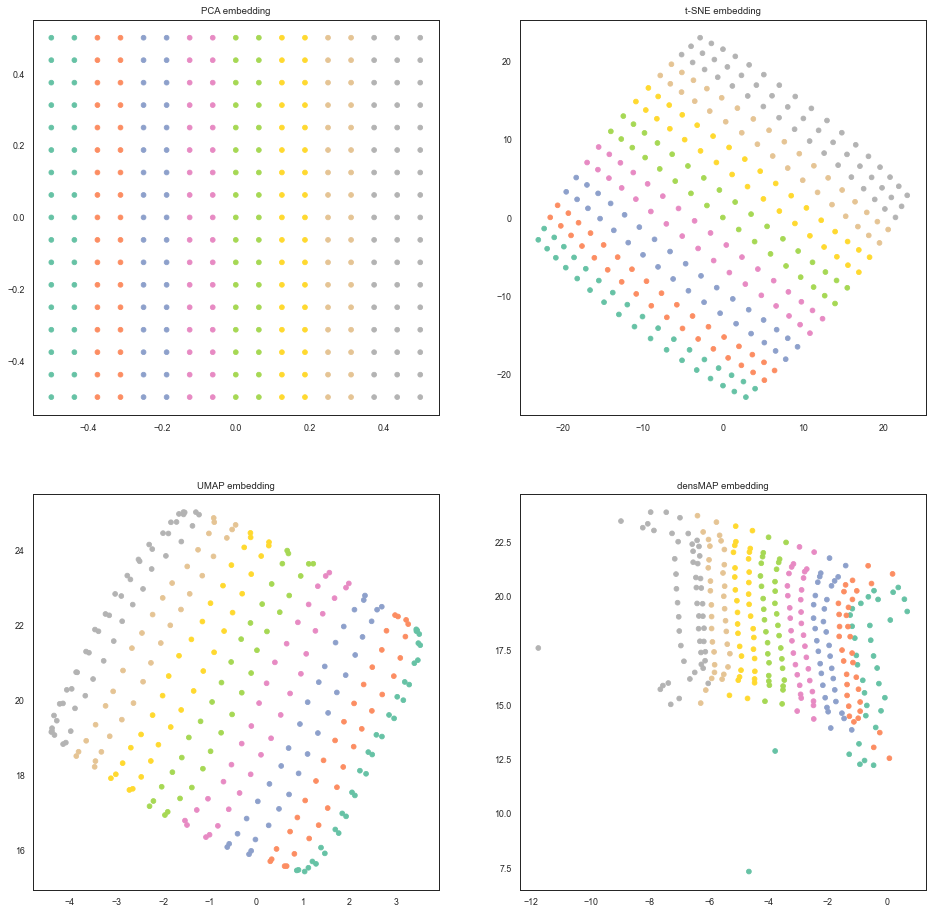

In [ ]:
import numpy as np

# Another example using a 2D uniform grid
x = np.linspace(0, 1, int(np.sqrt(300)))
xx, yy = np.meshgrid(x, x)
X = np.hstack(
    [
        xx.ravel().reshape(-1, 1),
        yy.ravel().reshape(-1, 1),
    ]
)
y_true = xx.ravel()


fig, ax = plt.subplots(2, 2, figsize =(16,16))

from sklearn.decomposition import PCA
pca_embedding = PCA(n_components = 2).fit_transform(X)
ax[0,0].scatter(*pca_embedding.T,  c=y_true,  cmap='Set2')
ax[0,0].set_title('PCA embedding')

from sklearn.manifold import TSNE
tsne_embedding = TSNE(n_components = 2, learning_rate  = 'auto', init = 'random').fit_transform(X)
ax[0,1].scatter(*tsne_embedding.T, c=y_true, cmap='Set2')
ax[0,1].set_title('t-SNE embedding')

umap_embedding = umap.UMAP(random_state=42).fit_transform(X)
ax[1,0].scatter(*umap_embedding.T, c=y_true,cmap='Set2')
ax[1,0].set_title('UMAP embedding')

dens_embedding = umap.UMAP(densmap=True, random_state=42).fit_transform(X)
ax[1,1].scatter(*dens_embedding.T,  c=y_true, cmap='Set2')
ax[1,1].set_title('densMAP embedding')

plt.show()


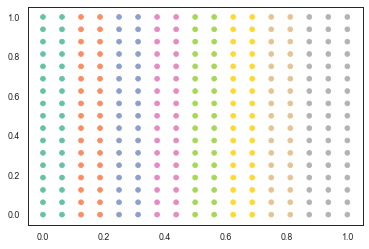

In [ ]:
plt.scatter(X[:,0],X[:,1], c = y_true, cmap = "Set2")

In [2]:
cd ../

/Users/sowonjeong/Documents/GitHub/gnumap


In [4]:
cd notebooks/

/Users/sowonjeong/Documents/GitHub/gnumap/notebooks


In [33]:
from sklearn.datasets import *
import networkx as nx
from torch_geometric.utils import to_networkx
X, y_true = make_blobs(
    n_samples=1500, centers=4, cluster_std=[0.1,0.1,1.0,1.0],
    random_state=0
)
new_data = convert_to_graph(X, n_neighbours = 50, features = 'none')
# G = to_networkx(new_data)
# nx.draw(G, pos = X, node_color = y_true, node_size = 100)

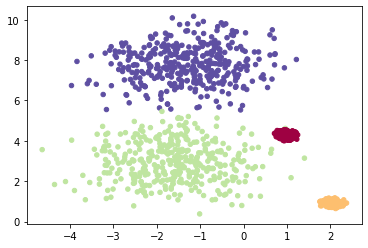

In [10]:
from sklearn.preprocessing import normalize
plt.scatter(X[:,0],X[:,1], c = y_true, cmap = 'Spectral', s = 20)

(array([  316.,  2592.,  7430., 13246., 11552.,  6518.,  2266.,  1626.,
        15956., 31464.]),
 array([0.030125  , 0.12700394, 0.22388287, 0.32076181, 0.41764074,
        0.51451968, 0.61139862, 0.70827755, 0.80515649, 0.90203542,
        0.99891436]),
 <BarContainer object of 10 artists>)

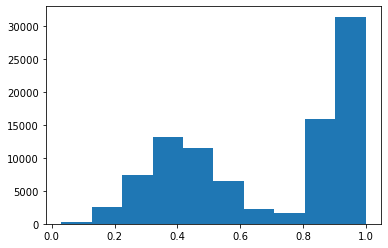

In [11]:
plt.hist(new_data.edge_weight)

Hyperparameters a = 1.89560586638432 and b = 0.8006378440415777
Epoch=000, loss=22.5203, time=1.4461
Epoch=001, loss=17.5437, time=0.9831
Epoch=002, loss=14.6854, time=1.0267
Epoch=003, loss=13.6184, time=1.1225
Epoch=004, loss=12.9313, time=1.1391
Epoch=005, loss=12.2902, time=1.2692
Epoch=006, loss=11.7162, time=1.2095
Epoch=007, loss=11.1827, time=1.1134
Epoch=008, loss=10.7005, time=1.2371
Epoch=009, loss=10.2764, time=1.2299
Epoch=010, loss=9.8819, time=1.3600
Epoch=011, loss=9.5477, time=1.3452
Epoch=012, loss=9.2294, time=1.2182
Epoch=013, loss=8.9595, time=1.1777
Epoch=014, loss=8.6915, time=1.1241
Epoch=015, loss=8.4458, time=1.0288
Epoch=016, loss=8.2149, time=1.0993
Epoch=017, loss=8.0090, time=1.1465
Epoch=018, loss=7.8063, time=1.0897
Epoch=019, loss=7.6326, time=1.0551
Epoch=020, loss=7.4678, time=0.9879
Epoch=021, loss=7.3224, time=1.2750
Epoch=022, loss=7.1732, time=1.3188
Epoch=023, loss=7.0343, time=1.0220
Epoch=024, loss=6.8985, time=1.6055
Epoch=025, loss=6.7802, ti

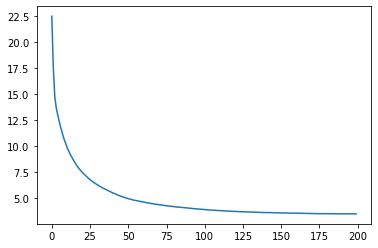

In [87]:
model, target_index, losses  = train_gnumap(new_data, 512, 2, n_layers=2, dropout_rate = 0.5, target=None,
                 patience=20, epochs=200, lr=1e-2, wd=1e-3, optim = 'Adam',
                 min_dist=0.01, name_file="1", subsampling=None,
                 spread = 1.0, repulsion_strength=None,
                 device=None, verbose = False, normalized = True)
out = model(new_data.x.float(), new_data.edge_index, new_data.edge_weight)
plt.plot(losses)

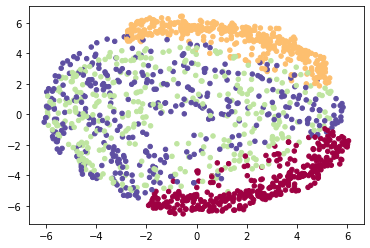

In [88]:
from sklearn.preprocessing import normalize
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = y_true, cmap = 'Spectral', s = 20)

Hyperparameters a = 1.89560586638432 and b = 0.8006378440415777
Epoch=000, loss=22.4821, time=1.6007
Epoch=001, loss=22.4069, time=1.1732
Epoch=002, loss=22.2443, time=1.4802
Epoch=003, loss=22.1010, time=1.1813
Epoch=004, loss=22.0150, time=1.2392
Epoch=005, loss=21.9472, time=1.3053
Epoch=006, loss=21.8990, time=1.0691
Epoch=007, loss=21.7940, time=1.1230
Epoch=008, loss=21.7142, time=1.0027
Epoch=009, loss=21.6251, time=1.1311
Epoch=010, loss=21.5056, time=1.1468
Epoch=011, loss=21.3990, time=1.1577
Epoch=012, loss=21.3302, time=0.9923
Epoch=013, loss=21.2219, time=1.0039
Epoch=014, loss=21.1251, time=1.0628
Epoch=015, loss=21.0776, time=1.1021
Epoch=016, loss=20.9613, time=0.9406
Epoch=017, loss=20.8381, time=0.9567
Epoch=018, loss=20.7058, time=0.9867
Epoch=019, loss=20.5963, time=1.0095
Epoch=020, loss=20.4948, time=1.1833
Epoch=021, loss=20.3927, time=1.1111
Epoch=022, loss=20.2387, time=1.0869
Epoch=023, loss=20.1057, time=0.9785
Epoch=024, loss=20.0189, time=1.0017
Epoch=025, 

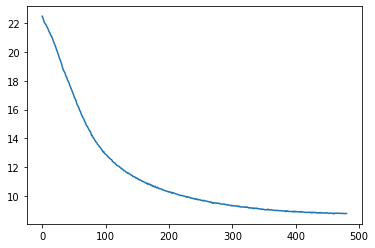

In [49]:
model, target_index, losses  = train_gnumap(new_data, 512, 2, n_layers=2, dropout_rate = 0.5, target=None,
                 patience=20, epochs=500, lr=1e-3, wd=1e-4, optim = 'SGD',
                 min_dist=0.01, name_file="1", subsampling=None,
                 spread = 1.0, repulsion_strength=None,
                 device=None, verbose = False, normalized = True)
out = model(new_data.x.float(), new_data.edge_index, new_data.edge_weight)
plt.plot(losses)

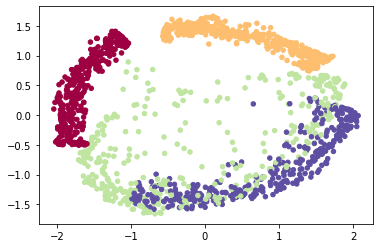

In [50]:
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = y_true, cmap = 'Spectral', s = 20)

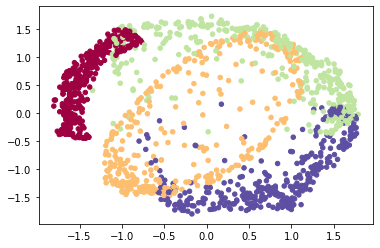

In [13]:
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = y_true, cmap = 'Spectral', s = 20)

In [14]:
from sklearn import manifold, datasets

X, y_true = datasets.make_circles(
    n_samples=1500, factor=0.2, noise=0.1, random_state=0
)
new_data = convert_to_graph(X, n_neighbours = 50, features = 'none')
# G = to_networkx(new_data)
# nx.draw(G, pos = X, node_color = y_true, node_size = 100)

(array([ 1246., 12590., 12504., 12052., 15824., 10078., 23646., 46028.,
        26360.,  5950.]),
 array([0.36373298, 0.4271869 , 0.49064083, 0.55409475, 0.61754868,
        0.6810026 , 0.74445653, 0.80791045, 0.87136438, 0.9348183 ,
        0.99827223]),
 <BarContainer object of 10 artists>)

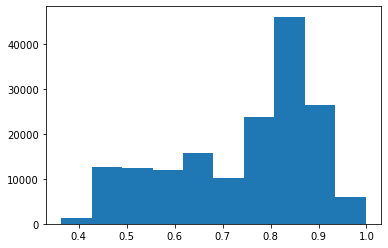

In [15]:
plt.hist(new_data.edge_weight)

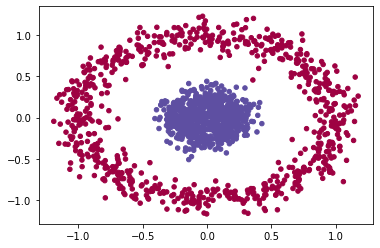

In [16]:
from sklearn.preprocessing import normalize
plt.scatter(X[:,0],X[:,1], c = y_true, cmap = 'Spectral', s = 20)

Hyperparameters a = 1.89560586638432 and b = 0.8006378440415777
Epoch=000, loss=12.1858, time=3.1012
Epoch=001, loss=11.9053, time=1.9197
Epoch=002, loss=11.8251, time=1.8199
Epoch=003, loss=11.7407, time=1.6072
Epoch=004, loss=11.8524, time=1.6660
Epoch=005, loss=11.9376, time=1.6411
Epoch=006, loss=11.9227, time=1.5660
Epoch=007, loss=11.8584, time=1.7534
Epoch=008, loss=11.9212, time=1.6019
Epoch=009, loss=11.9384, time=1.5492
Epoch=010, loss=12.0234, time=1.5636
Epoch=011, loss=11.9835, time=1.5070
Epoch=012, loss=11.9104, time=1.5015
Epoch=013, loss=11.8646, time=1.6121
Epoch=014, loss=12.0766, time=1.5322
Epoch=015, loss=12.0817, time=1.5120
Epoch=016, loss=12.0511, time=1.5249
Epoch=017, loss=11.9280, time=1.5627
Epoch=018, loss=11.6274, time=1.5178
Epoch=019, loss=11.9662, time=1.5679
Epoch=020, loss=11.9429, time=1.6569
Epoch=021, loss=12.0693, time=1.6623
Epoch=022, loss=12.0557, time=1.5588
Epoch=023, loss=12.1286, time=1.5356
Epoch=024, loss=12.1522, time=1.5175
Epoch=025, 

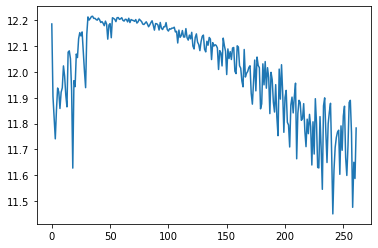

In [22]:
model, target_index, losses  = train_gnumap(new_data, 512, 2, n_layers=2, dropout_rate = 0.5, target=None,
                 patience=20, epochs=500, lr=1e-2, wd=1e-1, optim = 'SGD',
                 min_dist=0.01, name_file="1", subsampling=None,
                 spread = 1.0, repulsion_strength=None,
                 device=None, verbose = False, normalized = True)
out = model(new_data.x.float(), new_data.edge_index, new_data.edge_weight)
plt.plot(losses)

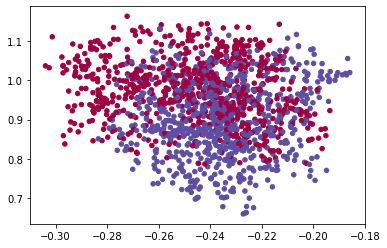

In [23]:
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = y_true, cmap = 'Spectral', s = 20)

In [24]:
X, y_true = datasets.make_moons(
    n_samples=1500,noise=0.1, random_state=0
)
new_data = convert_to_graph(X, n_neighbours = 100, features = 'none')

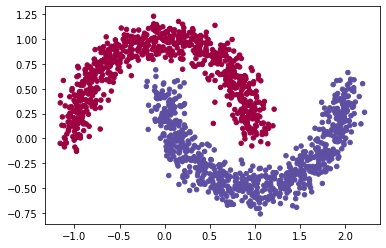

In [25]:
plt.scatter(X[:,0],X[:,1], c = y_true, cmap = 'Spectral', s = 20)

In [28]:
model, target_index, losses  = train_gnumap(new_data, 512, 2, n_layers=2, dropout_rate = 0.5, target=None,
                 patience=20, epochs=500, lr=1e-2, wd=1e-1, optim = 'SGD',
                 min_dist=0.01, name_file="1", subsampling=None,
                 spread = 1.0, repulsion_strength=None,
                 device=None, verbose = False, normalized = True)
out = model(new_data.x.float(), new_data.edge_index, new_data.edge_weight)
plt.plot(losses)

Hyperparameters a = 1.89560586638432 and b = 0.8006378440415777
Epoch=000, loss=12.1546, time=1.8670
Epoch=001, loss=11.8984, time=1.7681
Epoch=002, loss=11.8664, time=1.9906
Epoch=003, loss=11.6754, time=2.1924
Epoch=004, loss=11.7271, time=1.9935
Epoch=005, loss=12.0144, time=1.8212
Epoch=006, loss=11.9980, time=2.0308
Epoch=007, loss=11.9385, time=1.9151
Epoch=008, loss=11.7766, time=1.5300
Epoch=009, loss=11.8585, time=1.6257
Epoch=010, loss=11.9167, time=1.5757
Epoch=011, loss=12.0383, time=1.6971
Epoch=012, loss=11.9839, time=2.0484
Epoch=013, loss=11.8657, time=1.6896
Epoch=014, loss=12.0485, time=1.6858
Epoch=015, loss=12.0088, time=1.8916
Epoch=016, loss=11.9384, time=1.8295
Epoch=017, loss=11.9863, time=1.7871
Epoch=018, loss=12.1553, time=1.7050
Epoch=019, loss=12.2019, time=1.6048
Epoch=020, loss=12.2039, time=1.5926
Epoch=021, loss=12.2152, time=1.5324
Epoch=022, loss=12.2108, time=1.6915
Epoch=023, loss=12.2028, time=1.5107
Epoch=024, loss=12.2127, time=1.5404
Epoch=025, 

KeyboardInterrupt: 

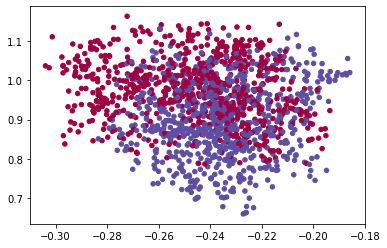

In [27]:
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = y_true, cmap = 'Spectral', s = 20)

In [230]:
X, y_true = datasets.make_s_curve(n_samples = 1500, random_state=0)
new_data = convert_to_graph(X, n_neighbours = 100, features = 'none')

(array([ 2644., 28856., 36930., 42698., 31742., 11018.,  7412.,  4516.,
         2460.,   750.]),
 array([0.16450306, 0.24765298, 0.33080291, 0.41395283, 0.49710276,
        0.58025268, 0.66340261, 0.74655253, 0.82970246, 0.91285238,
        0.99600231]),
 <BarContainer object of 10 artists>)

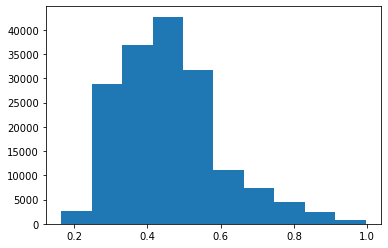

In [200]:
plt.hist(new_data.edge_weight)

Hyperparameters a = 1.89560586638432 and b = 0.8006378440415777
Epoch=000, loss=14.3950, time=1.4597
Epoch=001, loss=14.0983, time=1.4832
Epoch=002, loss=14.0208, time=1.5105
Epoch=003, loss=13.8860, time=1.5572
Epoch=004, loss=14.0784, time=1.4593
Epoch=005, loss=14.1219, time=1.4561
Epoch=006, loss=14.1240, time=1.4669
Epoch=007, loss=14.0361, time=1.5778
Epoch=008, loss=13.9470, time=1.4003
Epoch=009, loss=14.1418, time=1.3825
Epoch=010, loss=14.2819, time=1.4789
Epoch=011, loss=14.2364, time=1.3844
Epoch=012, loss=14.1070, time=1.4330
Epoch=013, loss=14.0108, time=1.4906
Epoch=014, loss=14.1866, time=1.4278
Epoch=015, loss=14.3590, time=1.5243
Epoch=016, loss=14.3907, time=1.3833
Epoch=017, loss=14.3948, time=1.4592
Epoch=018, loss=14.3955, time=1.3806
Epoch=019, loss=14.3690, time=1.4659
Epoch=020, loss=14.3471, time=1.3812
Epoch=021, loss=14.3087, time=1.4507
Epoch=022, loss=14.1337, time=1.3735
Epoch=023, loss=14.0849, time=1.3811
Epoch=024, loss=14.3523, time=1.4620
Epoch=025, 

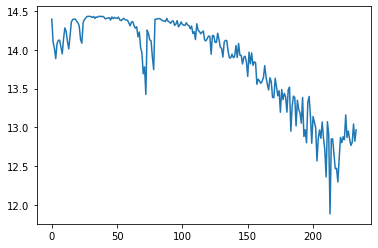

In [231]:
model, target_index, losses  = train_gnumap(new_data, 512, 2, n_layers=2, dropout_rate = 0.5, target=None,
                 patience=20, epochs=500, lr=1e-2, wd=1e-3, optim = 'SGD',
                 min_dist=0.01, name_file="1", subsampling=None,
                 spread = 1.0, repulsion_strength=None,
                 device=None, verbose = False, normalized = True)
out = model(new_data.x.float(), new_data.edge_index, new_data.edge_weight)
plt.plot(losses)

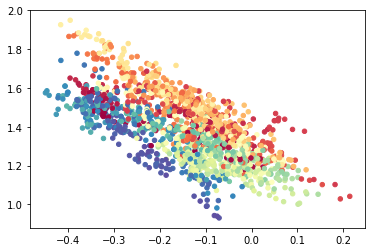

In [232]:
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = y_true, cmap = 'Spectral', s = 20)

In [68]:
import numpy as np
samples = np.random.choice(mnist.data.shape[0],3000)
new_data = convert_to_graph(mnist.data.to_numpy()[samples,:], n_neighbours = 5, features = 'none')
# G = to_networkx(new_data)
# nx.draw(G, node_color = color[samples], node_size = 10)

NameError: name 'mnist' is not defined

In [ ]:
mnist2 = PCA(n_components = 2).fit_transform(mnist.data).embedding
mnist5 = PCA(n_components = 5).fit_transform(mnist.data).embedding
mnist10 = PCA(n_components = 10).fit_transform(mnist.data).embedding
mnist20 = PCA(n_components = 20).fit_transform(mnist.data).embedding
mnist50 = PCA(n_components = 50).fit_transform(mnist.data).embedding
mnist100 = PCA(n_components = 100).fit_transform(mnist.data).embedding
mnist250 = PCA(n_components = 250).fit_transform(mnist.data).embedding
mnist500 = PCA(n_components = 500).fit_transform(mnist.data).embedding

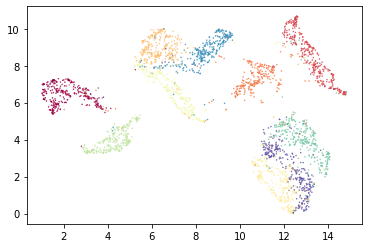

In [6]:
umap_embedding = umap.UMAP(random_state=42).fit_transform(mnist.data.to_numpy()[samples,:])
plt.scatter(*umap_embedding.T, s = 0.2, c=color[samples], cmap='Spectral')

Hyperparameters a = 1.5769434603113077 and b = 0.8950608779109733
Epoch=000, loss=439.3143, time=0.2480
Epoch=001, loss=439.3145, time=0.2521
Epoch=002, loss=439.3144, time=0.2313
Epoch=003, loss=439.3134, time=0.2414
Epoch=004, loss=439.3130, time=0.2286
Epoch=005, loss=439.3113, time=0.3165
Epoch=006, loss=439.3035, time=0.2424
Epoch=007, loss=439.2966, time=0.2203
Epoch=008, loss=439.2523, time=0.2260
Epoch=009, loss=438.8269, time=0.2157
Epoch=010, loss=418.4709, time=0.2111
Epoch=011, loss=81.7043, time=0.1923
Epoch=012, loss=14.3636, time=0.1932
Epoch=013, loss=6.8650, time=0.2193
Epoch=014, loss=5.4868, time=0.1879
Epoch=015, loss=5.2282, time=0.1903
Epoch=016, loss=5.1524, time=0.1813
Epoch=017, loss=5.2201, time=0.1959
Epoch=018, loss=5.2774, time=0.1834
Epoch=019, loss=5.3446, time=0.1896
Epoch=020, loss=5.4533, time=0.1846
Epoch=021, loss=5.4863, time=0.1990
Epoch=022, loss=5.5413, time=0.1897
Epoch=023, loss=5.5754, time=0.1891
Epoch=024, loss=5.6232, time=0.1794
Epoch=025,

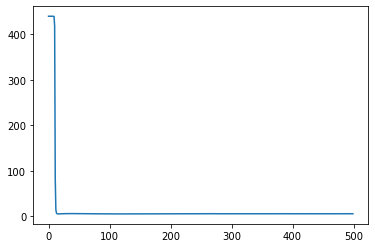

In [25]:
new_data = convert_to_graph(mnist.data.to_numpy()[samples,:], n_neighbours = 5, features = 'none')
model, target_index, losses  = train_gnumap(new_data, 512, 2, n_layers=2, dropout_rate = 0.7, target=None,
                 patience=20, epochs=500, lr=1e-1, wd=1e-2,
                 min_dist=0.1, name_file="1", subsampling=None,
                 spread = 1.0, repulsion_strength=None,
                 device=None, verbose = False, normalized = False)
out = model(new_data.x.float(), new_data.edge_index)
plt.plot(losses)

In [120]:
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = color[samples], cmap = 'Set2', s = 20)

NameError: name 'color' is not defined

In [24]:
new_data.__class__ == torch_geometric.data.data.Data

True